# Class 3 - Linear regression

## Linear regression: the model

Linear models are widely used and form the foundation of many advanced non-linear techniques such as support vector machines and neural networks. You propably have seen an image depicting linear regression already:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, model_selection, linear_model, metrics

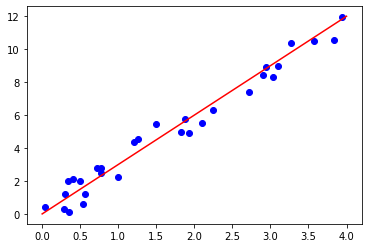

In [2]:
n = 30
beta = 3

x = 4*np.random.random(n)
eps = 2*np.random.random(n)-1
y = x*beta + eps

plt.plot(x,y,'ob',[0,4],[0,4*beta],'r')
plt.show()

Consider $\mathcal{X} = ℝ^d$ and $\mathcal{Y} = ℝ$. For linear regression, we assume that the data are of the form $$y \approx \sum_{j=1}^d β_j x^{(j)} + β_0.$$ Hence, we choose the hypothesis as the class of affine functions: $$\{x\mapsto \langleβ,x\rangle + β_0 \;\vert\; β_0,…,β_d ∈ℝ\}.$$

Usually, it is more convenient to incorporate the bias $β_0$ into the variables $β$ as well. To do so, denote $x_0 = 1$ and consider instead $\mathcal{X} = ℝ^{d+1}$ with $x = (1,x^{(1)},…,x^{(d)})$. We will do so explicitly later on and hence will work with the hypothesis class of linear functions instead:
$$\mathcal{F} = \{x\mapsto \langleβ,x\rangle \;\vert\; β∈ℝ^{d+1}\}$$

Which loss function should we choose? It is common to consider one of the following two:
- squared error (OLS) $L(y,y') = (y - y')^2$
- absolute value loss function $L(y,y') = |y−y'|$

where $y$ is the true label and $y'$ is our prediction of it.

**Attention!** When choosing an error function, it is generally a good idea to stick with a few, usual, well-known choices. These two are most commonly used because of a lot of reasons coming from statistics (e.g. sparsity) and/or optimization (e.g. convexity).

Denote $X = (x_i^{(j)})_{i,j}$ the matrix with rows given by $x_1,…,x_n$. Then, we end up with the following problem: Find $\operatorname{argmin}_{h∈\mathcal{F}} \hat{R}(h)$ or more explicitely
* $\operatorname{argmin}\{ \frac{1}{n} \sum_{i=1}^n (y_i − \langleβ,x_i\rangle)^2 \;\vert\; β∈ℝ^d\} = \operatorname{argmin}\frac{1}{n} \|Xβ−y\|_2^2$, resp.
* $\operatorname{argmin}\{ \frac{1}{n} \sum_{i=1}^n |y_i − \langleβ,x_i\rangle| \;\vert\; β∈ℝ^d\} = \operatorname{argmin}\frac{1}{n} \|Xβ−y\|_1$

Advantages:
- Easy to understand model
- Scale well on large datasets
- Work well with sparse data
- Quite stable for small changes in the input data
- Rarely overfits (low variance)


Disadvantages:
- Linear model might not be realistic
- Tendency to underfit (high bias)
- Cannot treat well strongly correlated features e.g. $x_1 = −x_2$

## Linear regression: the algorithm (from scratch)

We will present the algorithms on the Boston house price data set from scikit-learn. Throughout the whole part we will use the squared error.

In [3]:
boston = datasets.load_boston()

print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [4]:
print(boston.data.shape)
print(boston.target.shape)

(506, 13)
(506,)


In [5]:
x, y = boston.data, boston.target
y = y.reshape((y.shape[0], 1))

print(x.shape)
print(y.shape)

(506, 13)
(506, 1)


### Data preprocessing

In general it is a bad idea to immediately start training your machine learning algorithm: we first need to __preprocess__ the data.

#### Shuffling

Usually, datapoints in a sample are not realizations of a perfectly i.i.d. sequence of random variables. Instead, the sample might be generated in such a way that the datapoints have some degree of time dependence without us noticing, or they might be correlated in some other way among each other. 

Moreover, some algorithms may depend on the order of the datapoints in the sample.

In order to reduce these efffects as much as possible,it is always a good idea to shuffle the datapoints before usage.

In [6]:
print(x)

[[6.3200e-03 1.8000e+01 2.3100e+00 ... 1.5300e+01 3.9690e+02 4.9800e+00]
 [2.7310e-02 0.0000e+00 7.0700e+00 ... 1.7800e+01 3.9690e+02 9.1400e+00]
 [2.7290e-02 0.0000e+00 7.0700e+00 ... 1.7800e+01 3.9283e+02 4.0300e+00]
 ...
 [6.0760e-02 0.0000e+00 1.1930e+01 ... 2.1000e+01 3.9690e+02 5.6400e+00]
 [1.0959e-01 0.0000e+00 1.1930e+01 ... 2.1000e+01 3.9345e+02 6.4800e+00]
 [4.7410e-02 0.0000e+00 1.1930e+01 ... 2.1000e+01 3.9690e+02 7.8800e+00]]


In [7]:
np.random.seed(seed=1500)

def shuffle(x, y):
    z = np.hstack((x, y))
    np.random.shuffle(z)
    return np.hsplit(z, [x.shape[1]])

x, y = shuffle(x, y)

In [8]:
print(x)

[[4.29400e-02 2.80000e+01 1.50400e+01 ... 1.82000e+01 3.96900e+02
  1.05900e+01]
 [9.32909e+00 0.00000e+00 1.81000e+01 ... 2.02000e+01 3.96900e+02
  1.81300e+01]
 [2.89600e-01 0.00000e+00 9.69000e+00 ... 1.92000e+01 3.96900e+02
  2.11400e+01]
 ...
 [2.18700e-02 6.00000e+01 2.93000e+00 ... 1.56000e+01 3.93370e+02
  5.03000e+00]
 [5.02300e-02 3.50000e+01 6.06000e+00 ... 1.69000e+01 3.94020e+02
  1.24300e+01]
 [9.60400e-02 4.00000e+01 6.41000e+00 ... 1.76000e+01 3.96900e+02
  2.98000e+00]]


#### Train and test splitting

To obtain a result of how good our model will be we cannot plainly use the empirical error obtained on the training dataset. This error is biased as we trained the model in such a way as to minimize it!

Instead, one typically would like to compute the empirical error on new, previously unseen data to obtain a better estimate of how good the model describes reality. These "new, previously unseen" data must be set aside from the beginning and separated from the training dataset into a test dataset.

The test dataset will not be used for training and we will use it only at end, in order to come up with an estimate of how good our model is.

The process of evaluating the prediction error of our model using the empirical error on the test dataset is called testing. As a rule of thumb around 20% of your total data should be hold back for testing in the end.

In [9]:
def splitting(x, y, test_size=0.2):
    n = x.shape[0]
    train_size = int(n * (1 - test_size))
    return x[:train_size, ], x[train_size:, ], y[:train_size, ], y[train_size:, ]

x_train, x_test, y_train, y_test = splitting(x, y)

In [10]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test: ", y_test.shape)

x_train:  (404, 13)
y_train:  (404, 1)
x_test:  (102, 13)
y_test:  (102, 1)


#### Passage from affine functions to linear ones

Usually, it is more convenient to incorporate the bias $β_0$ into the variables $β$ as well. To do so, denote $x_0 = 1$ and consider instead $\mathcal{X} = ℝ^{d+1}$ with: $$x = (1,x^{(1)},…,x^{(d)}).$$ We will do so explicitly later on and hence will work with the hypothesis class of linear functions instead:
$$\mathcal{F} = \{x\mapsto \langleβ,x\rangle \;\vert\; β∈ℝ^{d+1}\}$$


In [11]:
x_train = np.hstack((np.ones((x_train.shape[0],1)), x_train))
x_test = np.hstack((np.ones((x_test.shape[0],1)), x_test))

print(x_train.shape)
print(x_test.shape)

(404, 14)
(102, 14)


#### Interlude: normalization

Sometimes there is a need to normalize all features in order for them to live on the same scale. This procedure is called feature scaling or normalization. 

In the special case of linear regression this is usually not needed, even though some implementations of linear regression might still profit from data being not too large. There are algorithms that cannot be run without normalization, therefore it's important to understand this data preprocessing technique.

Normalization means that we center and rescale all our datapoints, so that they have zero (sample) mean and unit (sample) variance. In the case of multi-dimensional features, the normalization is done component-wise:

$$x_{new}^{(j)} = \frac{x_{old}^{(j)}−x_{mean}^{(j)}}{x_{std}^{(j)}},$$

while for labels the whole vector is normalized:

$$y_{new} = \frac{y_{old} − y_{mean}}{y_{std}}.$$

**Attention!** If you decide to normalize, remember to normalize only your training dataset! Otherwise you will partially contaminate the test dataset by incorporating (some) information about its sample mean and variance.

**Attention!** When you need to output your predictions (on the test dataset or outside of it) make sure that you reverse the normalization operation. Your model has learnt to predict from normalized input!

We will not implement normalization today, but the commented code below can be used to normalize a **training dataset**.

In [12]:
# x_mean = np.mean(x_train, axis=0)
# x_std = np.std(x_train, axis=0)

# x_train = (x_train - x_mean)/x_std

In [13]:
# Check that all coordinates of the data matrix X have mean zero and variance one

# print(np.mean(x_train, axis=0))
# print(np.std(x_train, axis=0))

In [14]:
# y_mean = np.mean(y_train)
# y_std = np.std(y_train)

# y_train = (y_train - y_mean)/y_std

In [15]:
# Check that the label vector has now mean zero and variance one

# print(np.mean(y_train))
# print(np.std(y_train))

#### Empirical error function

Before starting, let's implement a function that will allow us to compute the error according our definition of empirical error. Remember that we want to have mean squared loss. In other words, we want to evaluate the error between the real label vector $y$ and the predicted label vector $y'$ using the (squared) L^2 norm:

$$ L(y,y') = \frac{1}{n} \sum_{i=1}^n (y_i - {y'}_i)^2. $$

This function will be used to compute both the training and test error.

In [16]:
def my_error(y_true, y_pred):
    return (1/len(y_true))*sum((y_true - y_pred)**2)

### (Batch) Gradient descent

Remember that our strategy is to find the vector of coefficients, $\beta$, that minimizes the empirical error on our dataset:

$$\operatorname{argmin}\{ \frac{1}{n} \sum_{i=1}^n (y_i − \langleβ,x_i\rangle)^2 \;\vert\; β∈ℝ^d\} = \operatorname{argmin}\frac{1}{n} \|Xβ−y\|_2^2$$

The function $β \mapsto \frac{1}{n} \|Xβ−y\|_2^2$ is convex and we may want to apply a standard gradient descent method to find its minimum. 

The gradient is given by
$$\nabla_β \frac{1}{n} \|Xβ−y\|_2^2 = \frac{2}{n}(X^t X β − X^t y).$$

Fix some step length/learning rate $α∈ℝ_+$ and a starting estimate for $\beta$ (we can take, for example, the origin). Then, we update our estimate by "moving towards the minimum":

$$ β_{new} = β_{old} − \frac{2α}{n}(X^t X β − X^t y)$$

until the algorithm converges.

What is the role of $α$? 

In theory, the smaller $\alpha$ is, the smaller each step is, which means that you will be able to identify your point of minimum very precisely, but your algorithm will require a lot of time for convergence.

The bigger $\alpha$ is, the faster you can move towards the minimum, but you will identify it with less precision.

In practice a variety of recipes can be used for choosing a "good" alpha. Ideally we would like $\alpha$ to start big (so we can zoom fast towards the minimum) and then become smaller (so we can identify the point of minimum with more precision). In other words, one can choose $α$ depending on the iteration step. 

A typical choice (so called Gauss-Newton algorithm) is: 

$$α = \frac{(\nabla_β \frac{1}{n} \|Xβ−y\|_2^2)^t (\nabla_β \frac{1}{n} \|Xβ−y\|_2^2)}{(\nabla_β \frac{1}{n} \|Xβ−y\|_2^2)^t x^t x (\nabla_β \frac{1}{n} \|Xβ−y\|_2^2)}$$ 

Another approach is to fix an arbitrary $\alpha$ from the beginning and treat it as a model parameter (called hyperparameter). Of course, this particular choice of $\alpha$ will impact the efficiency of the minimization and in the course of our class we will study techniques (cross-validation for hyperparameter selection) that will allow us to learn how to select a good value for $\alpha$, specifically suited for the problem we want to solve.

Below is an implementation:

In [17]:
def linear_regression_gradient_train(x, y, alpha=None):
    
    n, d = x.shape
    result = np.zeros((d, 1))
    cost_new = my_error(y, x.dot(result))
    cost_old = 0
    i = 0
    while np.abs(cost_new - cost_old) > 10 ** (-6):
        print(i)
        print(cost_new)
        gradient = (np.transpose(x)).dot(x.dot(result) - y)
        alpha = (np.transpose(gradient).dot(gradient)) / (
            (np.transpose(gradient).dot(np.transpose(x))).dot(x.dot(gradient)))
        result -= (2 * alpha / n) * gradient
        cost_new, cost_old = my_error(y, x.dot(result)), cost_new
        i += 1
    print("Iterations: {}".format(i))
    return result

beta_gradient = linear_regression_gradient_train(x_train, y_train)

0
[588.72608911]
1
[584.14246689]
2
[579.60376507]
3
[575.10954019]
4
[570.6593532]
5
[566.25276936]
6
[561.88935824]
7
[557.56869365]
8
[553.29035362]
9
[549.05392032]
10
[544.85898008]
11
[540.7051233]
12
[536.59194442]
13
[532.5190419]
14
[528.48601814]
15
[524.49247949]
16
[520.53803619]
17
[516.62230229]
18
[512.7448957]
19
[508.90543808]
20
[505.10355483]
21
[501.33887503]
22
[497.61103146]
23
[493.91966049]
24
[490.26440211]
25
[486.64489984]
26
[483.06080073]
27
[479.51175534]
28
[475.99741763]
29
[472.51744502]
30
[469.07149829]
31
[465.65924158]
32
[462.28034234]
33
[458.93447131]
34
[455.62130248]
35
[452.34051305]
36
[449.09178343]
37
[445.87479715]
38
[442.6892409]
39
[439.53480445]
40
[436.41118062]
41
[433.31806528]
42
[430.2551573]
43
[427.22215853]
44
[424.21877374]
45
[421.24471064]
46
[418.29967982]
47
[415.38339472]
48
[412.49557161]
49
[409.63592957]
50
[406.80419044]
51
[404.00007883]
52
[401.22332205]
53
[398.4736501]
54
[395.75079566]
55
[393.05449403]
56
[390.3

500
[112.21516059]
501
[112.09902577]
502
[111.98180414]
503
[111.86344174]
504
[111.74388247]
505
[111.62306799]
506
[111.50093768]
507
[111.37742854]
508
[111.25247516]
509
[111.12600963]
510
[110.99796153]
511
[110.86825791]
512
[110.73682326]
513
[110.60357952]
514
[110.46844618]
515
[110.33134028]
516
[110.19217659]
517
[110.05086776]
518
[109.90732451]
519
[109.76145598]
520
[109.61317005]
521
[109.46237377]
522
[109.30897396]
523
[109.15287784]
524
[108.99399377]
525
[108.8322322]
526
[108.66750666]
527
[108.49973497]
528
[108.32884055]
529
[108.15475386]
530
[107.97741403]
531
[107.79677049]
532
[107.61278481]
533
[107.42543248]
534
[107.23470475]
535
[107.04061032]
536
[106.84317699]
537
[106.64245299]
538
[106.43850811]
539
[106.23143435]
540
[106.02134618]
541
[105.80838029]
542
[105.59269473]
543
[105.3744676]
544
[105.15389514]
545
[104.9311893]
546
[104.70657499]
547
[104.48028701]
548
[104.25256672]
549
[104.02365881]
550
[103.79380799]
551
[103.56325594]
552
[103.332238

1043
[77.22335452]
1044
[77.21710931]
1045
[77.21079506]
1046
[77.20440711]
1047
[77.19794043]
1048
[77.19138962]
1049
[77.18474886]
1050
[77.17801191]
1051
[77.17117197]
1052
[77.16422172]
1053
[77.15715319]
1054
[77.1499577]
1055
[77.14262579]
1056
[77.13514712]
1057
[77.12751031]
1058
[77.11970287]
1059
[77.11171102]
1060
[77.10351949]
1061
[77.09511132]
1062
[77.0864676]
1063
[77.07756719]
1064
[77.06838633]
1065
[77.05889822]
1066
[77.04907248]
1067
[77.03887457]
1068
[77.02826495]
1069
[77.01719814]
1070
[77.0056216]
1071
[76.99347418]
1072
[76.98068437]
1073
[76.96716794]
1074
[76.95282508]
1075
[76.93753672]
1076
[76.92115985]
1077
[76.9035217]
1078
[76.88441241]
1079
[76.86357618]
1080
[76.8407009]
1081
[76.81540741]
1082
[76.78724095]
1083
[76.75567082]
1084
[76.72011001]
1085
[76.67997349]
1086
[76.63479494]
1087
[76.58439961]
1088
[76.52906981]
1089
[76.46957667]
1090
[76.4069988]
1091
[76.3424247]
1092
[76.27673077]
1093
[76.21051861]
1094
[76.14415914]
1095
[76.07786555]


1480
[67.23515664]
1481
[67.22593288]
1482
[67.22061933]
1483
[67.19352135]
1484
[67.1922684]
1485
[67.18967038]
1486
[67.17193331]
1487
[67.17009565]
1488
[67.16404129]
1489
[67.14793379]
1490
[67.14588651]
1491
[67.13769959]
1492
[67.13102879]
1493
[67.11947941]
1494
[67.11617221]
1495
[67.06640105]
1496
[67.06523153]
1497
[67.06291012]
1498
[67.05042793]
1499
[67.04759735]
1500
[67.0207581]
1501
[67.01957953]
1502
[67.01721181]
1503
[67.00361184]
1504
[67.00117313]
1505
[66.98595559]
1506
[66.98388484]
1507
[66.9749986]
1508
[66.96986425]
1509
[66.94315963]
1510
[66.94201168]
1511
[66.93973509]
1512
[66.92750948]
1513
[66.92472392]
1514
[66.89792779]
1515
[66.89680218]
1516
[66.89459434]
1517
[66.8833869]
1518
[66.88022612]
1519
[66.83246813]
1520
[66.83148028]
1521
[66.82971341]
1522
[66.82378891]
1523
[66.80949832]
1524
[66.80738882]
1525
[66.79743892]
1526
[66.79365519]
1527
[66.72041495]
1528
[66.70667886]
1529
[66.70453261]
1530
[66.69363963]
1531
[66.69056162]
1532
[66.6426825

1940
[62.02111789]
1941
[62.02049577]
1942
[62.01935162]
1943
[62.01493966]
1944
[62.01008259]
1945
[62.0063601]
1946
[61.9978744]
1947
[61.99666489]
1948
[61.99141923]
1949
[61.988362]
1950
[61.96793182]
1951
[61.96752907]
1952
[61.96695001]
1953
[61.96593474]
1954
[61.96272965]
1955
[61.94693877]
1956
[61.94641492]
1957
[61.94555258]
1958
[61.94337373]
1959
[61.83746086]
1960
[61.83651759]
1961
[61.83380301]
1962
[61.79556797]
1963
[61.79532655]
1964
[61.79503164]
1965
[61.79465107]
1966
[61.79411335]
1967
[61.79320626]
1968
[61.79071937]
1969
[61.72242369]
1970
[61.72220665]
1971
[61.72194757]
1972
[61.72162479]
1973
[61.72119503]
1974
[61.72055216]
1975
[61.71931383]
1976
[61.71332011]
1977
[61.71121494]
1978
[61.61118248]
1979
[61.61067262]
1980
[61.60983187]
1981
[61.60769552]
1982
[61.49967198]
1983
[61.49799917]
1984
[61.47310462]
1985
[61.47279678]
1986
[61.47239036]
1987
[61.47179195]
1988
[61.47068299]
1989
[61.46625214]
1990
[61.46227032]
1991
[61.45683025]
1992
[61.4544250

2416
[58.67565158]
2417
[58.6753976]
2418
[58.67505345]
2419
[58.67452095]
2420
[58.6734004]
2421
[58.66381627]
2422
[58.66334517]
2423
[58.66245198]
2424
[58.65845702]
2425
[58.65644206]
2426
[58.62743166]
2427
[58.62726607]
2428
[58.62706735]
2429
[58.62681783]
2430
[58.62648128]
2431
[58.62596517]
2432
[58.62490492]
2433
[58.61729051]
2434
[58.61665795]
2435
[58.61504699]
2436
[58.52200401]
2437
[58.52076148]
2438
[58.50293257]
2439
[58.5026983]
2440
[58.50238775]
2441
[58.50192705]
2442
[58.50105738]
2443
[58.49725077]
2444
[58.49511842]
2445
[58.47736328]
2446
[58.47712937]
2447
[58.47681919]
2448
[58.47635871]
2449
[58.47548794]
2450
[58.47164349]
2451
[58.46957889]
2452
[58.4483146]
2453
[58.44811508]
2454
[58.44786296]
2455
[58.4475193]
2456
[58.44698123]
2457
[58.44581123]
2458
[58.43269275]
2459
[58.43238136]
2460
[58.43191721]
2461
[58.43103068]
2462
[58.42691193]
2463
[58.42517134]
2464
[58.35521771]
2465
[58.3550539]
2466
[58.35485653]
2467
[58.3546072]
2468
[58.35426752]


2923
[55.85289423]
2924
[55.85255217]
2925
[55.85190287]
2926
[55.84897441]
2927
[55.84755034]
2928
[55.82109606]
2929
[55.82099564]
2930
[55.82087944]
2931
[55.82074101]
2932
[55.82056905]
2933
[55.82034116]
2934
[55.82000319]
2935
[55.81936567]
2936
[55.81657938]
2937
[55.81500165]
2938
[55.80225948]
2939
[55.8020877]
2940
[55.80185996]
2941
[55.80152194]
2942
[55.80088307]
2943
[55.79806335]
2944
[55.79654174]
2945
[55.78083058]
2946
[55.7806886]
2947
[55.78051079]
2948
[55.780272]
2949
[55.77990885]
2950
[55.77917884]
2951
[55.77461552]
2952
[55.77401674]
2953
[55.77169058]
2954
[55.76920081]
2955
[55.7671465]
2956
[55.76344721]
2957
[55.76259285]
2958
[55.75307642]
2959
[55.75284884]
2960
[55.75251019]
2961
[55.75186602]
2962
[55.74892881]
2963
[55.74757181]
2964
[55.71293761]
2965
[55.71284895]
2966
[55.71274834]
2967
[55.71263159]
2968
[55.71249194]
2969
[55.71231742]
2970
[55.71208386]
2971
[55.71173104]
2972
[55.71103398]
2973
[55.70711583]
2974
[55.70636084]
2975
[55.70096517

3415
[53.72316301]
3416
[53.72295407]
3417
[53.72260883]
3418
[53.72172411]
3419
[53.65611554]
3420
[53.65476216]
3421
[53.65021956]
3422
[53.64992978]
3423
[53.64930909]
3424
[53.64308588]
3425
[53.64289134]
3426
[53.64258086]
3427
[53.64186678]
3428
[53.62703461]
3429
[53.62695005]
3430
[53.62684962]
3431
[53.62672544]
3432
[53.62656209]
3433
[53.62632316]
3434
[53.62588699]
3435
[53.62425152]
3436
[53.62206043]
3437
[53.62105557]
3438
[53.59243018]
3439
[53.59237101]
3440
[53.59230498]
3441
[53.59223004]
3442
[53.59214309]
3443
[53.59203909]
3444
[53.59190911]
3445
[53.59173518]
3446
[53.59147242]
3447
[53.59095314]
3448
[53.5880198]
3449
[53.58746495]
3450
[53.58364459]
3451
[53.58328299]
3452
[53.58227129]
3453
[53.55668648]
3454
[53.55662575]
3455
[53.55655767]
3456
[53.55647995]
3457
[53.55638903]
3458
[53.55627903]
3459
[53.5561392]
3460
[53.55594662]
3461
[53.55563875]
3462
[53.55492711]
3463
[53.53918003]
3464
[53.53910101]
3465
[53.53900824]
3466
[53.53889539]
3467
[53.53875

3854
[52.2304718]
3855
[52.23041907]
3856
[52.23035931]
3857
[52.23029008]
3858
[52.23020747]
3859
[52.23010459]
3860
[52.2299677]
3861
[52.22976311]
3862
[52.22936959]
3863
[52.22745942]
3864
[52.22679146]
3865
[52.17991651]
3866
[52.17985654]
3867
[52.17978691]
3868
[52.17970355]
3869
[52.17959926]
3870
[52.17945942]
3871
[52.17924735]
3872
[52.178824]
3873
[52.17627334]
3874
[52.17589266]
3875
[52.17414686]
3876
[52.17335794]
3877
[52.14706584]
3878
[52.14702369]
3879
[52.14697735]
3880
[52.14692574]
3881
[52.14686732]
3882
[52.14679976]
3883
[52.14671931]
3884
[52.14661945]
3885
[52.14648727]
3886
[52.14629169]
3887
[52.14592462]
3888
[52.14435449]
3889
[52.14335721]
3890
[52.13848319]
3891
[52.13833112]
3892
[52.13808919]
3893
[52.13753782]
3894
[52.12708]
3895
[52.12700939]
3896
[52.12692442]
3897
[52.12681729]
3898
[52.12667177]
3899
[52.1264455]
3900
[52.12596247]
3901
[52.12122013]
3902
[52.12106406]
3903
[52.12081165]
3904
[52.12020715]
3905
[52.09771014]
3906
[52.09766668]
3

4289
[51.12954575]
4290
[51.12950207]
4291
[51.12945251]
4292
[51.12939503]
4293
[51.12932633]
4294
[51.12924056]
4295
[51.12912596]
4296
[51.12895337]
4297
[51.12861481]
4298
[51.12677612]
4299
[51.12637135]
4300
[51.1223753]
4301
[51.12224627]
4302
[51.1220392]
4303
[51.12155485]
4304
[51.10846216]
4305
[51.10841953]
4306
[51.10837134]
4307
[51.1083157]
4308
[51.10824959]
4309
[51.10816782]
4310
[51.10806018]
4311
[51.10790249]
4312
[51.10761359]
4313
[51.10651002]
4314
[51.10518212]
4315
[51.10438488]
4316
[51.09929962]
4317
[51.09920245]
4318
[51.09906611]
4319
[51.09883953]
4320
[51.09824709]
4321
[51.04717931]
4322
[51.04704506]
4323
[51.04682273]
4324
[51.04624825]
4325
[50.99270558]
4326
[50.98469373]
4327
[50.98463407]
4328
[50.9845617]
4329
[50.98446934]
4330
[50.98434128]
4331
[50.98413364]
4332
[50.98363236]
4333
[50.9616079]
4334
[50.9615764]
4335
[50.96154212]
4336
[50.96150442]
4337
[50.96146242]
4338
[50.96141483]
4339
[50.96135973]
4340
[50.96129404]
4341
[50.96121232]

4788
[49.97119122]
4789
[49.96983373]
4790
[49.96945551]
4791
[49.9607865]
4792
[49.96074836]
4793
[49.96070444]
4794
[49.96065245]
4795
[49.96058846]
4796
[49.96050492]
4797
[49.96038437]
4798
[49.96017106]
4799
[49.95946871]
4800
[49.95690925]
4801
[49.9567736]
4802
[49.95651106]
4803
[49.95518718]
4804
[49.95479305]
4805
[49.9422046]
4806
[49.94217543]
4807
[49.94214321]
4808
[49.9421071]
4809
[49.94206588]
4810
[49.94201767]
4811
[49.94195937]
4812
[49.94188529]
4813
[49.94178335]
4814
[49.94162064]
4815
[49.94124594]
4816
[49.93287195]
4817
[49.93283317]
4818
[49.93278832]
4819
[49.93273494]
4820
[49.93266869]
4821
[49.93258105]
4822
[49.93245148]
4823
[49.93220876]
4824
[49.93117726]
4825
[49.93049604]
4826
[49.92763188]
4827
[49.92751628]
4828
[49.92731663]
4829
[49.92671828]
4830
[49.9207005]
4831
[49.92064913]
4832
[49.92058597]
4833
[49.92050365]
4834
[49.92038519]
4835
[49.92017698]
4836
[49.91950941]
4837
[49.91638133]
4838
[49.91627824]
4839
[49.91611214]
4840
[49.91571875

5238
[49.16472186]
5239
[49.16468191]
5240
[49.16463393]
5241
[49.16457358]
5242
[49.16449195]
5243
[49.16436604]
5244
[49.16410293]
5245
[49.16190195]
5246
[49.16178897]
5247
[49.16157385]
5248
[49.16057974]
5249
[49.16014398]
5250
[49.13822674]
5251
[49.13820911]
5252
[49.13819037]
5253
[49.13817033]
5254
[49.13814875]
5255
[49.13812532]
5256
[49.13809962]
5257
[49.13807107]
5258
[49.13803886]
5259
[49.13800178]
5260
[49.13795788]
5261
[49.13790388]
5262
[49.13783341]
5263
[49.13773181]
5264
[49.13755238]
5265
[49.13696577]
5266
[49.1346645]
5267
[49.13455939]
5268
[49.13436916]
5269
[49.1336796]
5270
[49.13249696]
5271
[49.1321988]
5272
[49.1276328]
5273
[49.12758469]
5274
[49.127524]
5275
[49.12744151]
5276
[49.12731303]
5277
[49.12703736]
5278
[49.12416122]
5279
[49.12408196]
5280
[49.12396101]
5281
[49.12371549]
5282
[49.1220516]
5283
[49.12188647]
5284
[49.12140917]
5285
[49.11316665]
5286
[49.11313812]
5287
[49.11310591]
5288
[49.11306878]
5289
[49.11302479]
5290
[49.11297055]


5675
[48.61404038]
5676
[48.6130091]
5677
[48.61272801]
5678
[48.60677486]
5679
[48.60674468]
5680
[48.60670962]
5681
[48.60666762]
5682
[48.60661501]
5683
[48.60654433]
5684
[48.60643673]
5685
[48.60621969]
5686
[48.60480772]
5687
[48.60464697]
5688
[48.60411855]
5689
[48.60213732]
5690
[48.60203911]
5691
[48.60185524]
5692
[48.60107465]
5693
[48.60055445]
5694
[48.59842765]
5695
[48.59833832]
5696
[48.59818213]
5697
[48.59769093]
5698
[48.5948311]
5699
[48.59476883]
5700
[48.59467938]
5701
[48.59452273]
5702
[48.59402722]
5703
[48.59131625]
5704
[48.59125013]
5705
[48.59115252]
5706
[48.59097029]
5707
[48.59020766]
5708
[48.58965967]
5709
[48.58800786]
5710
[48.58788233]
5711
[48.5875862]
5712
[48.57787321]
5713
[48.57785265]
5714
[48.57783014]
5715
[48.57780518]
5716
[48.57777708]
5717
[48.57774484]
5718
[48.57770684]
5719
[48.57766039]
5720
[48.57760037]
5721
[48.57751537]
5722
[48.57737111]
5723
[48.57696533]
5724
[48.56546878]
5725
[48.56545034]
5726
[48.56543041]
5727
[48.565408

6154
[48.00219007]
6155
[48.0020524]
6156
[48.00161704]
6157
[47.9992095]
6158
[47.99915235]
6159
[47.99906864]
6160
[47.99891529]
6161
[47.99832794]
6162
[47.99762351]
6163
[47.99719889]
6164
[47.99444172]
6165
[47.99439285]
6166
[47.99432574]
6167
[47.99421911]
6168
[47.99397667]
6169
[47.98923296]
6170
[47.98920467]
6171
[47.98917136]
6172
[47.98913068]
6173
[47.9890782]
6174
[47.98900406]
6175
[47.98887894]
6176
[47.9885338]
6177
[47.97349291]
6178
[47.97348]
6179
[47.97346637]
6180
[47.97345188]
6181
[47.97343641]
6182
[47.97341977]
6183
[47.97340171]
6184
[47.97338194]
6185
[47.97336001]
6186
[47.97333532]
6187
[47.97330696]
6188
[47.97327354]
6189
[47.97323265]
6190
[47.97317976]
6191
[47.97310468]
6192
[47.97297668]
6193
[47.97261045]
6194
[47.96479104]
6195
[47.96477238]
6196
[47.96475185]
6197
[47.96472896]
6198
[47.96470301]
6199
[47.96467292]
6200
[47.96463699]
6201
[47.96459218]
6202
[47.96453242]
6203
[47.96444272]
6204
[47.9642682]
6205
[47.96335818]
6206
[47.96312197]
6

6596
[47.37371752]
6597
[47.37364679]
6598
[47.37352002]
6599
[47.37307895]
6600
[47.37204436]
6601
[47.37191397]
6602
[47.37143607]
6603
[47.37066923]
6604
[47.37044518]
6605
[47.36354666]
6606
[47.36353073]
6607
[47.36351325]
6608
[47.36349384]
6609
[47.36347194]
6610
[47.36344673]
6611
[47.3634169]
6612
[47.36338022]
6613
[47.36333237]
6614
[47.36326344]
6615
[47.36314195]
6616
[47.36274723]
6617
[47.3610724]
6618
[47.36100764]
6619
[47.3608981]
6620
[47.3605934]
6621
[47.34904724]
6622
[47.34903577]
6623
[47.34902364]
6624
[47.34901072]
6625
[47.34899689]
6626
[47.34898197]
6627
[47.34896573]
6628
[47.34894787]
6629
[47.34892796]
6630
[47.34890539]
6631
[47.34887925]
6632
[47.34884806]
6633
[47.34880922]
6634
[47.34875755]
6635
[47.34868033]
6636
[47.34853173]
6637
[47.34780253]
6638
[47.34755786]
6639
[47.32791504]
6640
[47.32790562]
6641
[47.32789581]
6642
[47.32788556]
6643
[47.32787481]
6644
[47.3278635]
6645
[47.32785153]
6646
[47.3278388]
6647
[47.32782519]
6648
[47.32781052]

7061
[46.94413534]
7062
[46.94408961]
7063
[46.94402227]
7064
[46.94389737]
7065
[46.94338953]
7066
[46.94295984]
7067
[46.9422352]
7068
[46.94204688]
7069
[46.93873422]
7070
[46.93870946]
7071
[46.93867968]
7072
[46.93864214]
7073
[46.93859116]
7074
[46.93851192]
7075
[46.93834272]
7076
[46.93662885]
7077
[46.93657818]
7078
[46.93649963]
7079
[46.93633327]
7080
[46.9347622]
7081
[46.93470578]
7082
[46.93461282]
7083
[46.93437644]
7084
[46.89596274]
7085
[46.89594884]
7086
[46.89593366]
7087
[46.89591689]
7088
[46.89589809]
7089
[46.89587663]
7090
[46.89585153]
7091
[46.89582116]
7092
[46.89578257]
7093
[46.89572942]
7094
[46.89564447]
7095
[46.89544779]
7096
[46.89041578]
7097
[46.89039911]
7098
[46.89038043]
7099
[46.89035914]
7100
[46.89033426]
7101
[46.89030422]
7102
[46.89026614]
7103
[46.89021395]
7104
[46.89013131]
7105
[46.88994526]
7106
[46.88667991]
7107
[46.8866554]
7108
[46.8866259]
7109
[46.88658868]
7110
[46.88653809]
7111
[46.88645928]
7112
[46.88629]
7113
[46.88448033]


7498
[46.53717366]
7499
[46.50671043]
7500
[46.50670286]
7501
[46.50669501]
7502
[46.50668683]
7503
[46.50667828]
7504
[46.50666931]
7505
[46.50665987]
7506
[46.50664988]
7507
[46.50663926]
7508
[46.50662789]
7509
[46.50661563]
7510
[46.50660231]
7511
[46.50658768]
7512
[46.50657139]
7513
[46.50655298]
7514
[46.50653171]
7515
[46.50650643]
7516
[46.50647513]
7517
[46.50643388]
7518
[46.5063733]
7519
[46.50626159]
7520
[46.50581996]
7521
[46.50538041]
7522
[46.50493486]
7523
[46.50450685]
7524
[46.50402442]
7525
[46.5036813]
7526
[46.50259245]
7527
[46.5025189]
7528
[46.50235826]
7529
[46.50033876]
7530
[46.50030503]
7531
[46.50025937]
7532
[46.50018887]
7533
[46.50004099]
7534
[46.49875098]
7535
[46.49869288]
7536
[46.49858886]
7537
[46.49822819]
7538
[46.49735335]
7539
[46.49725108]
7540
[46.49690664]
7541
[46.49584507]
7542
[46.49576905]
7543
[46.4955971]
7544
[46.4923768]
7545
[46.49235602]
7546
[46.49233143]
7547
[46.49230118]
7548
[46.4922617]
7549
[46.49220478]
7550
[46.49210422]

7937
[46.01518945]
7938
[46.01512196]
7939
[46.01497114]
7940
[46.01252492]
7941
[46.01250304]
7942
[46.0124762]
7943
[46.01244131]
7944
[46.01239137]
7945
[46.0123046]
7946
[46.01203786]
7947
[46.00994276]
7948
[46.00991709]
7949
[46.00988418]
7950
[46.0098382]
7951
[46.00976236]
7952
[46.00956879]
7953
[45.96959687]
7954
[45.9695856]
7955
[45.9695733]
7956
[45.9695597]
7957
[45.96954448]
7958
[45.96952711]
7959
[45.96950682]
7960
[45.96948231]
7961
[45.96945122]
7962
[45.96940857]
7963
[45.96934091]
7964
[45.96918773]
7965
[45.96626589]
7966
[45.9662479]
7967
[45.96622672]
7968
[45.96620088]
7969
[45.96616757]
7970
[45.96612062]
7971
[45.96604172]
7972
[45.96582711]
7973
[45.9503497]
7974
[45.9503437]
7975
[45.95033752]
7976
[45.95033113]
7977
[45.95032452]
7978
[45.95031765]
7979
[45.95031051]
7980
[45.95030305]
7981
[45.95029524]
7982
[45.95028702]
7983
[45.95027834]
7984
[45.95026912]
7985
[45.95025928]
7986
[45.95024869]
7987
[45.95023721]
7988
[45.95022463]
7989
[45.9502107]
799

8396
[45.69783668]
8397
[45.69782811]
8398
[45.69781898]
8399
[45.69780919]
8400
[45.69779859]
8401
[45.69778702]
8402
[45.69777425]
8403
[45.69775995]
8404
[45.69774364]
8405
[45.69772459]
8406
[45.69770161]
8407
[45.69767249]
8408
[45.69763263]
8409
[45.69756965]
8410
[45.69742876]
8411
[45.6951073]
8412
[45.69508735]
8413
[45.695063]
8414
[45.69503161]
8415
[45.69498735]
8416
[45.69491294]
8417
[45.69471014]
8418
[45.68049755]
8419
[45.68049196]
8420
[45.6804862]
8421
[45.68048026]
8422
[45.68047411]
8423
[45.68046774]
8424
[45.68046112]
8425
[45.68045421]
8426
[45.68044698]
8427
[45.68043939]
8428
[45.68043139]
8429
[45.68042291]
8430
[45.68041388]
8431
[45.68040419]
8432
[45.68039372]
8433
[45.6803823]
8434
[45.6803697]
8435
[45.68035562]
8436
[45.6803396]
8437
[45.68032093]
8438
[45.68029849]
8439
[45.68027023]
8440
[45.6802319]
8441
[45.68017249]
8442
[45.68004658]
8443
[45.67884435]
8444
[45.67880265]
8445
[45.6787349]
8446
[45.67856995]
8447
[45.66728019]
8448
[45.66727411]
84

8853
[45.39991345]
8854
[45.39989634]
8855
[45.39987589]
8856
[45.39985036]
8857
[45.39981622]
8858
[45.39976475]
8859
[45.39966341]
8860
[45.39909392]
8861
[45.39898389]
8862
[45.39818678]
8863
[45.39812349]
8864
[45.39797057]
8865
[45.38906021]
8866
[45.38905405]
8867
[45.38904763]
8868
[45.38904092]
8869
[45.38903388]
8870
[45.38902647]
8871
[45.38901862]
8872
[45.38901027]
8873
[45.38900132]
8874
[45.38899168]
8875
[45.38898118]
8876
[45.38896963]
8877
[45.38895676]
8878
[45.38894218]
8879
[45.3889253]
8880
[45.38890516]
8881
[45.3888801]
8882
[45.3888468]
8883
[45.38879712]
8884
[45.38870193]
8885
[45.38824465]
8886
[45.38807577]
8887
[45.34802607]
8888
[45.34801803]
8889
[45.34800946]
8890
[45.34800024]
8891
[45.34799025]
8892
[45.34797932]
8893
[45.34796723]
8894
[45.34795363]
8895
[45.34793807]
8896
[45.34791978]
8897
[45.34789751]
8898
[45.34786894]
8899
[45.34782894]
8900
[45.34776273]
8901
[45.34759158]
8902
[45.30215833]
8903
[45.26757111]
8904
[45.26756584]
8905
[45.267560

9327
[44.95744241]
9328
[44.95743359]
9329
[44.95742398]
9330
[44.95741341]
9331
[44.95740162]
9332
[44.95738825]
9333
[44.95737275]
9334
[44.95735423]
9335
[44.95733113]
9336
[44.95730029]
9337
[44.95725393]
9338
[44.95716331]
9339
[44.95667552]
9340
[44.95656399]
9341
[44.95530838]
9342
[44.95528066]
9343
[44.95524096]
9344
[44.95517187]
9345
[44.95495836]
9346
[44.95336688]
9347
[44.95334572]
9348
[44.95331829]
9349
[44.95327916]
9350
[44.95321172]
9351
[44.95301072]
9352
[44.95059039]
9353
[44.95057661]
9354
[44.95056055]
9355
[44.95054121]
9356
[44.95051676]
9357
[44.95048346]
9358
[44.95043133]
9359
[44.95031778]
9360
[44.94891352]
9361
[44.94888925]
9362
[44.94885626]
9363
[44.94880486]
9364
[44.94869442]
9365
[44.9474978]
9366
[44.94746854]
9367
[44.9474256]
9368
[44.9473465]
9369
[44.94703457]
9370
[44.9467176]
9371
[44.94641534]
9372
[44.94606667]
9373
[44.9458342]
9374
[44.94486142]
9375
[44.94482355]
9376
[44.94475959]
9377
[44.94458242]
9378
[44.93604939]
9379
[44.93604406

9821
[44.64765783]
9822
[44.64765203]
9823
[44.64764594]
9824
[44.64763951]
9825
[44.6476327]
9826
[44.64762544]
9827
[44.64761765]
9828
[44.64760922]
9829
[44.64760003]
9830
[44.64758988]
9831
[44.64757852]
9832
[44.64756558]
9833
[44.64755048]
9834
[44.64753228]
9835
[44.64750926]
9836
[44.64747785]
9837
[44.64742852]
9838
[44.64732009]
9839
[44.64584188]
9840
[44.64582192]
9841
[44.64579599]
9842
[44.64575887]
9843
[44.64569434]
9844
[44.64549561]
9845
[44.64394299]
9846
[44.64392409]
9847
[44.64389993]
9848
[44.64386633]
9849
[44.64381149]
9850
[44.64367601]
9851
[44.62914406]
9852
[44.62914021]
9853
[44.62913627]
9854
[44.62913225]
9855
[44.62912814]
9856
[44.62912393]
9857
[44.62911961]
9858
[44.62911516]
9859
[44.62911059]
9860
[44.62910586]
9861
[44.62910098]
9862
[44.62909592]
9863
[44.62909066]
9864
[44.62908518]
9865
[44.62907944]
9866
[44.62907342]
9867
[44.62906708]
9868
[44.62906035]
9869
[44.6290532]
9870
[44.62904553]
9871
[44.62903724]
9872
[44.62902821]
9873
[44.62901

10255
[44.42785329]
10256
[44.42779136]
10257
[44.42759923]
10258
[44.42622038]
10259
[44.42620086]
10260
[44.42617528]
10261
[44.42613814]
10262
[44.42607148]
10263
[44.42583731]
10264
[44.42531796]
10265
[44.4252452]
10266
[44.42494187]
10267
[44.42471688]
10268
[44.42410585]
10269
[44.42404992]
10270
[44.4238999]
10271
[44.4044925]
10272
[44.40448913]
10273
[44.40448571]
10274
[44.40448224]
10275
[44.4044787]
10276
[44.40447511]
10277
[44.40447144]
10278
[44.4044677]
10279
[44.40446388]
10280
[44.40445997]
10281
[44.40445596]
10282
[44.40445185]
10283
[44.40444763]
10284
[44.40444328]
10285
[44.4044388]
10286
[44.40443416]
10287
[44.40442936]
10288
[44.40442437]
10289
[44.40441917]
10290
[44.40441373]
10291
[44.40440803]
10292
[44.40440202]
10293
[44.40439566]
10294
[44.4043889]
10295
[44.40438165]
10296
[44.40437384]
10297
[44.40436534]
10298
[44.40435599]
10299
[44.40434557]
10300
[44.40433377]
10301
[44.40432011]
10302
[44.40430382]
10303
[44.40428356]
10304
[44.40425666]
10305
[

10684
[44.22790936]
10685
[44.22766556]
10686
[44.22729553]
10687
[44.22717314]
10688
[44.2164456]
10689
[44.21644187]
10690
[44.21643805]
10691
[44.21643413]
10692
[44.2164301]
10693
[44.21642596]
10694
[44.21642169]
10695
[44.21641728]
10696
[44.21641271]
10697
[44.21640797]
10698
[44.21640304]
10699
[44.21639788]
10700
[44.21639248]
10701
[44.2163868]
10702
[44.2163808]
10703
[44.21637443]
10704
[44.21636762]
10705
[44.21636029]
10706
[44.21635234]
10707
[44.21634363]
10708
[44.21633396]
10709
[44.21632308]
10710
[44.21631058]
10711
[44.21629584]
10712
[44.21627778]
10713
[44.21625439]
10714
[44.2162211]
10715
[44.21616399]
10716
[44.2159966]
10717
[44.21334998]
10718
[44.21334064]
10719
[44.21333018]
10720
[44.21331825]
10721
[44.21330429]
10722
[44.21328743]
10723
[44.21326603]
10724
[44.21323662]
10725
[44.21318982]
10726
[44.21308284]
10727
[44.21071385]
10728
[44.21070354]
10729
[44.21069181]
10730
[44.21067814]
10731
[44.21066168]
10732
[44.21064094]
10733
[44.21061278]
10734


11149
[43.99867078]
11150
[43.99866435]
11151
[43.99865744]
11152
[43.99864996]
11153
[43.99864179]
11154
[43.99863274]
11155
[43.99862259]
11156
[43.99861098]
11157
[43.99859736]
11158
[43.99858083]
11159
[43.9985597]
11160
[43.99853033]
11161
[43.99848243]
11162
[43.9983644]
11163
[43.98608672]
11164
[43.98608342]
11165
[43.98608006]
11166
[43.98607663]
11167
[43.98607312]
11168
[43.98606954]
11169
[43.98606587]
11170
[43.9860621]
11171
[43.98605823]
11172
[43.98605424]
11173
[43.98605013]
11174
[43.98604588]
11175
[43.98604148]
11176
[43.98603691]
11177
[43.98603215]
11178
[43.98602717]
11179
[43.98602195]
11180
[43.98601645]
11181
[43.98601063]
11182
[43.98600444]
11183
[43.98599782]
11184
[43.98599067]
11185
[43.98598291]
11186
[43.98597437]
11187
[43.98596487]
11188
[43.98595411]
11189
[43.98594168]
11190
[43.98592689]
11191
[43.98590854]
11192
[43.98588429]
11193
[43.98584848]
11194
[43.98578157]
11195
[43.98549898]
11196
[43.98530344]
11197
[43.98460163]
11198
[43.98456502]
111

11621
[43.78435759]
11622
[43.78365319]
11623
[43.78362007]
11624
[43.78355994]
11625
[43.78333785]
11626
[43.78299452]
11627
[43.78288596]
11628
[43.77650659]
11629
[43.77650244]
11630
[43.77649813]
11631
[43.77649364]
11632
[43.77648896]
11633
[43.77648405]
11634
[43.7764789]
11635
[43.77647346]
11636
[43.77646768]
11637
[43.77646152]
11638
[43.7764549]
11639
[43.77644772]
11640
[43.77643987]
11641
[43.77643119]
11642
[43.77642144]
11643
[43.77641028]
11644
[43.77639718]
11645
[43.77638125]
11646
[43.77636086]
11647
[43.77633241]
11648
[43.77628567]
11649
[43.77616778]
11650
[43.74876966]
11651
[43.74876694]
11652
[43.7487642]
11653
[43.74876143]
11654
[43.74875862]
11655
[43.74875579]
11656
[43.74875291]
11657
[43.74875]
11658
[43.74874704]
11659
[43.74874404]
11660
[43.748741]
11661
[43.7487379]
11662
[43.74873474]
11663
[43.74873152]
11664
[43.74872824]
11665
[43.74872488]
11666
[43.74872145]
11667
[43.74871793]
11668
[43.74871433]
11669
[43.74871062]
11670
[43.7487068]
11671
[43.

12054
[43.57787459]
12055
[43.57780824]
12056
[43.5774766]
12057
[43.57737348]
12058
[43.57206694]
12059
[43.57206261]
12060
[43.57205808]
12061
[43.57205334]
12062
[43.57204835]
12063
[43.57204308]
12064
[43.57203749]
12065
[43.57203151]
12066
[43.57202508]
12067
[43.5720181]
12068
[43.57201047]
12069
[43.572002]
12070
[43.57199247]
12071
[43.57198153]
12072
[43.57196865]
12073
[43.57195289]
12074
[43.57193253]
12075
[43.57190368]
12076
[43.57185468]
12077
[43.57171613]
12078
[43.56735607]
12079
[43.56735114]
12080
[43.56734593]
12081
[43.56734041]
12082
[43.56733452]
12083
[43.56732819]
12084
[43.56732133]
12085
[43.56731384]
12086
[43.56730556]
12087
[43.56729627]
12088
[43.56728565]
12089
[43.56727321]
12090
[43.56725812]
12091
[43.56723888]
12092
[43.56721221]
12093
[43.56716903]
12094
[43.56706494]
12095
[43.56090446]
12096
[43.56090051]
12097
[43.56089642]
12098
[43.56089217]
12099
[43.56088773]
12100
[43.56088309]
12101
[43.56087822]
12102
[43.56087308]
12103
[43.56086764]
1210

12468
[43.39343701]
12469
[43.39339806]
12470
[43.39331108]
12471
[43.3918796]
12472
[43.39186744]
12473
[43.39185266]
12474
[43.39183372]
12475
[43.39180731]
12476
[43.39176392]
12477
[43.39165453]
12478
[43.36505235]
12479
[43.36504992]
12480
[43.36504747]
12481
[43.36504501]
12482
[43.36504252]
12483
[43.36504]
12484
[43.36503747]
12485
[43.3650349]
12486
[43.36503231]
12487
[43.36502969]
12488
[43.36502703]
12489
[43.36502434]
12490
[43.36502161]
12491
[43.36501885]
12492
[43.36501603]
12493
[43.36501317]
12494
[43.36501026]
12495
[43.3650073]
12496
[43.36500428]
12497
[43.36500119]
12498
[43.36499803]
12499
[43.3649948]
12500
[43.36499148]
12501
[43.36498808]
12502
[43.36498458]
12503
[43.36498097]
12504
[43.36497724]
12505
[43.36497338]
12506
[43.36496937]
12507
[43.3649652]
12508
[43.36496084]
12509
[43.36495628]
12510
[43.36495148]
12511
[43.3649464]
12512
[43.36494102]
12513
[43.36493526]
12514
[43.36492907]
12515
[43.36492235]
12516
[43.36491499]
12517
[43.36490683]
12518
[43

12886
[43.16010116]
12887
[43.16009875]
12888
[43.16009632]
12889
[43.16009386]
12890
[43.16009138]
12891
[43.16008887]
12892
[43.16008632]
12893
[43.16008375]
12894
[43.16008114]
12895
[43.16007849]
12896
[43.1600758]
12897
[43.16007307]
12898
[43.16007029]
12899
[43.16006746]
12900
[43.16006457]
12901
[43.16006163]
12902
[43.16005862]
12903
[43.16005554]
12904
[43.16005238]
12905
[43.16004914]
12906
[43.16004581]
12907
[43.16004238]
12908
[43.16003884]
12909
[43.16003518]
12910
[43.16003139]
12911
[43.16002744]
12912
[43.16002333]
12913
[43.16001902]
12914
[43.1600145]
12915
[43.16000974]
12916
[43.16000469]
12917
[43.15999931]
12918
[43.15999354]
12919
[43.1599873]
12920
[43.1599805]
12921
[43.159973]
12922
[43.15996462]
12923
[43.15995508]
12924
[43.15994398]
12925
[43.15993062]
12926
[43.15991381]
12927
[43.15989103]
12928
[43.15985575]
12929
[43.15978117]
12930
[43.15907835]
12931
[43.15905319]
12932
[43.15901202]
12933
[43.15890934]
12934
[43.14189361]
12935
[43.14189122]
12936


[42.94511243]
13327
[42.94505939]
13328
[42.94485089]
13329
[42.94463406]
13330
[42.94444081]
13331
[42.94416474]
13332
[42.94405912]
13333
[42.88808009]
13334
[42.88763664]
13335
[42.88759369]
13336
[42.88747319]
13337
[42.88284676]
13338
[42.88284297]
13339
[42.88283902]
13340
[42.88283489]
13341
[42.88283054]
13342
[42.88282595]
13343
[42.88282109]
13344
[42.8828159]
13345
[42.88281032]
13346
[42.88280429]
13347
[42.88279769]
13348
[42.8827904]
13349
[42.88278223]
13350
[42.88277288]
13351
[42.88276194]
13352
[42.88274868]
13353
[42.88273178]
13354
[42.8827084]
13355
[42.88267066]
13356
[42.88258056]
13357
[42.8782272]
13358
[42.87822327]
13359
[42.87821915]
13360
[42.87821482]
13361
[42.87821026]
13362
[42.87820542]
13363
[42.87820026]
13364
[42.87819471]
13365
[42.87818872]
13366
[42.87818217]
13367
[42.87817494]
13368
[42.87816684]
13369
[42.8781576]
13370
[42.8781468]
13371
[42.87813375]
13372
[42.87811718]
13373
[42.87809444]
13374
[42.87805827]
13375
[42.8779758]
13376
[42.876

13782
[42.67203349]
13783
[42.67201527]
13784
[42.67198887]
13785
[42.6719417]
13786
[42.67177915]
13787
[42.67135671]
13788
[42.67131461]
13789
[42.67119355]
13790
[42.66843]
13791
[42.66842486]
13792
[42.66841931]
13793
[42.66841328]
13794
[42.66840667]
13795
[42.66839931]
13796
[42.668391]
13797
[42.66838142]
13798
[42.66837006]
13799
[42.66835603]
13800
[42.66833763]
13801
[42.66831084]
13802
[42.66826244]
13803
[42.66808759]
13804
[42.66777133]
13805
[42.66770212]
13806
[42.667015]
13807
[42.66699379]
13808
[42.66696067]
13809
[42.66688905]
13810
[42.66605559]
13811
[42.66603884]
13812
[42.66601542]
13813
[42.6659767]
13814
[42.6658771]
13815
[42.61031424]
13816
[42.61030979]
13817
[42.61030507]
13818
[42.61030002]
13819
[42.61029459]
13820
[42.61028869]
13821
[42.61028223]
13822
[42.61027505]
13823
[42.61026697]
13824
[42.61025768]
13825
[42.61024671]
13826
[42.61023326]
13827
[42.61021579]
13828
[42.61019082]
13829
[42.61014759]
13830
[42.61001628]
13831
[42.60876365]
13832
[42.

14201
[42.35907225]
14202
[42.35906934]
14203
[42.35906635]
14204
[42.35906327]
14205
[42.35906008]
14206
[42.35905677]
14207
[42.35905333]
14208
[42.35904974]
14209
[42.35904599]
14210
[42.35904205]
14211
[42.3590379]
14212
[42.3590335]
14213
[42.35902881]
14214
[42.35902378]
14215
[42.35901835]
14216
[42.35901242]
14217
[42.35900588]
14218
[42.35899858]
14219
[42.35899026]
14220
[42.35898058]
14221
[42.35896895]
14222
[42.35895429]
14223
[42.35893444]
14224
[42.35890368]
14225
[42.35883867]
14226
[42.35822372]
14227
[42.35820197]
14228
[42.35816652]
14229
[42.35807937]
14230
[42.34879701]
14231
[42.34879471]
14232
[42.34879238]
14233
[42.34879001]
14234
[42.3487876]
14235
[42.34878515]
14236
[42.34878265]
14237
[42.3487801]
14238
[42.3487775]
14239
[42.34877483]
14240
[42.3487721]
14241
[42.3487693]
14242
[42.34876642]
14243
[42.34876346]
14244
[42.3487604]
14245
[42.34875724]
14246
[42.34875397]
14247
[42.34875057]
14248
[42.34874702]
14249
[42.34874332]
14250
[42.34873943]
14251
[4

14614
[42.20808233]
14615
[42.20807605]
14616
[42.20806904]
14617
[42.2080611]
14618
[42.20805189]
14619
[42.20804087]
14620
[42.20802713]
14621
[42.20800876]
14622
[42.20798109]
14623
[42.20792673]
14624
[42.20762385]
14625
[42.20756333]
14626
[42.20708856]
14627
[42.20705933]
14628
[42.20699903]
14629
[42.20653253]
14630
[42.20650255]
14631
[42.20643927]
14632
[42.20584813]
14633
[42.20582647]
14634
[42.20579075]
14635
[42.20569953]
14636
[42.15895928]
14637
[42.15895738]
14638
[42.15895548]
14639
[42.15895356]
14640
[42.15895163]
14641
[42.15894968]
14642
[42.15894773]
14643
[42.15894576]
14644
[42.15894378]
14645
[42.15894178]
14646
[42.15893976]
14647
[42.15893772]
14648
[42.15893567]
14649
[42.15893359]
14650
[42.15893149]
14651
[42.15892937]
14652
[42.15892722]
14653
[42.15892504]
14654
[42.15892284]
14655
[42.1589206]
14656
[42.15891832]
14657
[42.15891601]
14658
[42.15891366]
14659
[42.15891127]
14660
[42.15890883]
14661
[42.15890634]
14662
[42.15890379]
14663
[42.15890119]
14

15046
[42.0394968]
15047
[42.03949104]
15048
[42.03948468]
15049
[42.03947754]
15050
[42.03946938]
15051
[42.03945982]
15052
[42.03944824]
15053
[42.03943346]
15054
[42.03941299]
15055
[42.03937985]
15056
[42.03930009]
15057
[42.03454417]
15058
[42.03454124]
15059
[42.03453822]
15060
[42.03453508]
15061
[42.03453182]
15062
[42.03452841]
15063
[42.03452486]
15064
[42.03452112]
15065
[42.03451719]
15066
[42.03451302]
15067
[42.03450858]
15068
[42.03450382]
15069
[42.03449868]
15070
[42.03449308]
15071
[42.0344869]
15072
[42.03448001]
15073
[42.03447217]
15074
[42.03446307]
15075
[42.03445215]
15076
[42.03443845]
15077
[42.03442]
15078
[42.03439177]
15079
[42.034334]
15080
[42.0339122]
15081
[42.03387964]
15082
[42.03380272]
15083
[42.03077144]
15084
[42.03076748]
15085
[42.03076327]
15086
[42.03075879]
15087
[42.03075398]
15088
[42.03074878]
15089
[42.0307431]
15090
[42.03073684]
15091
[42.03072983]
15092
[42.03072183]
15093
[42.0307125]
15094
[42.03070125]
15095
[42.03068702]
15096
[42.

15511
[41.90141623]
15512
[41.90141221]
15513
[41.90140793]
15514
[41.90140336]
15515
[41.90139843]
15516
[41.90139307]
15517
[41.90138719]
15518
[41.90138064]
15519
[41.90137324]
15520
[41.9013647]
15521
[41.90135456]
15522
[41.90134201]
15523
[41.90132552]
15524
[41.90130137]
15525
[41.9012572]
15526
[41.90108836]
15527
[41.90087935]
15528
[41.90076425]
15529
[41.89945089]
15530
[41.89944296]
15531
[41.89943368]
15532
[41.89942246]
15533
[41.89940819]
15534
[41.89938854]
15535
[41.89935711]
15536
[41.89928409]
15537
[41.89716702]
15538
[41.89716192]
15539
[41.89715636]
15540
[41.89715021]
15541
[41.89714334]
15542
[41.8971355]
15543
[41.89712635]
15544
[41.89711532]
15545
[41.89710136]
15546
[41.89708229]
15547
[41.89705228]
15548
[41.89698589]
15549
[41.89600128]
15550
[41.8959906]
15551
[41.89597721]
15552
[41.89595919]
15553
[41.89593167]
15554
[41.89587559]
15555
[41.89547878]
15556
[41.89544486]
15557
[41.89535875]
15558
[41.85964593]
15559
[41.85964418]
15560
[41.85964243]
1556

15939
[41.77371302]
15940
[41.77370992]
15941
[41.7737067]
15942
[41.77370332]
15943
[41.77369979]
15944
[41.77369607]
15945
[41.77369214]
15946
[41.77368796]
15947
[41.77368348]
15948
[41.77367867]
15949
[41.77367344]
15950
[41.7736677]
15951
[41.77366131]
15952
[41.77365411]
15953
[41.77364581]
15954
[41.77363597]
15955
[41.77362384]
15956
[41.77360796]
15957
[41.77358494]
15958
[41.77354371]
15959
[41.77340026]
15960
[41.77305411]
15961
[41.7730139]
15962
[41.77287992]
15963
[41.77241294]
15964
[41.77238735]
15965
[41.77233764]
15966
[41.77207866]
15967
[41.772011]
15968
[41.77074893]
15969
[41.77074099]
15970
[41.77073165]
15971
[41.7707203]
15972
[41.77070573]
15973
[41.77068535]
15974
[41.77065167]
15975
[41.77056506]
15976
[41.70617191]
15977
[41.70616947]
15978
[41.70616698]
15979
[41.70616442]
15980
[41.70616179]
15981
[41.70615908]
15982
[41.70615629]
15983
[41.7061534]
15984
[41.7061504]
15985
[41.70614729]
15986
[41.70614404]
15987
[41.70614064]
15988
[41.70613707]
15989
[4

16367
[41.47260913]
16368
[41.47260496]
16369
[41.47260048]
16370
[41.47259563]
16371
[41.47259033]
16372
[41.47258448]
16373
[41.47257792]
16374
[41.47257042]
16375
[41.47256164]
16376
[41.47255102]
16377
[41.4725375]
16378
[41.47251882]
16379
[41.47248881]
16380
[41.47241809]
16381
[41.46974715]
16382
[41.46974337]
16383
[41.46973936]
16384
[41.46973507]
16385
[41.46973044]
16386
[41.46972542]
16387
[41.46971991]
16388
[41.46971378]
16389
[41.46970686]
16390
[41.46969888]
16391
[41.46968942]
16392
[41.46967776]
16393
[41.46966248]
16394
[41.46964028]
16395
[41.46960037]
16396
[41.46945927]
16397
[41.46915906]
16398
[41.46911338]
16399
[41.46889949]
16400
[41.46881041]
16401
[41.45089907]
16402
[41.4508974]
16403
[41.45089573]
16404
[41.45089405]
16405
[41.45089236]
16406
[41.45089067]
16407
[41.45088897]
16408
[41.45088727]
16409
[41.45088556]
16410
[41.45088384]
16411
[41.45088211]
16412
[41.45088037]
16413
[41.45087862]
16414
[41.45087686]
16415
[41.45087509]
16416
[41.4508733]
164

16798
[41.23118666]
16799
[41.2311844]
16800
[41.23118208]
16801
[41.2311797]
16802
[41.23117726]
16803
[41.23117474]
16804
[41.23117215]
16805
[41.23116946]
16806
[41.23116669]
16807
[41.2311638]
16808
[41.2311608]
16809
[41.23115766]
16810
[41.23115438]
16811
[41.23115091]
16812
[41.23114725]
16813
[41.23114336]
16814
[41.2311392]
16815
[41.23113471]
16816
[41.23112984]
16817
[41.23112449]
16818
[41.23111855]
16819
[41.23111183]
16820
[41.23110409]
16821
[41.23109491]
16822
[41.23108359]
16823
[41.23106875]
16824
[41.23104718]
16825
[41.23100836]
16826
[41.23087025]
16827
[41.23058948]
16828
[41.23054229]
16829
[41.2302825]
16830
[41.23022813]
16831
[41.2297495]
16832
[41.2297287]
16833
[41.2296922]
16834
[41.22957541]
16835
[41.22897056]
16836
[41.22895517]
16837
[41.22893243]
16838
[41.22888983]
16839
[41.22870721]
16840
[41.22858988]
16841
[41.22800048]
16842
[41.2279846]
16843
[41.22796076]
16844
[41.22791439]
16845
[41.22767051]
16846
[41.22760918]
16847
[41.22663319]
16848
[41.

17259
[41.03783765]
17260
[41.03783543]
17261
[41.03783316]
17262
[41.03783082]
17263
[41.03782842]
17264
[41.03782595]
17265
[41.0378234]
17266
[41.03782077]
17267
[41.03781804]
17268
[41.0378152]
17269
[41.03781224]
17270
[41.03780915]
17271
[41.03780591]
17272
[41.03780249]
17273
[41.03779887]
17274
[41.03779503]
17275
[41.0377909]
17276
[41.03778646]
17277
[41.03778161]
17278
[41.03777629]
17279
[41.03777035]
17280
[41.03776363]
17281
[41.03775583]
17282
[41.03774653]
17283
[41.03773494]
17284
[41.03771952]
17285
[41.03769644]
17286
[41.03765185]
17287
[41.03742675]
17288
[41.03735959]
17289
[41.03472137]
17290
[41.03471793]
17291
[41.03471428]
17292
[41.03471039]
17293
[41.03470622]
17294
[41.03470172]
17295
[41.03469681]
17296
[41.0346914]
17297
[41.03468536]
17298
[41.03467849]
17299
[41.03467049]
17300
[41.0346609]
17301
[41.03464885]
17302
[41.03463257]
17303
[41.03460756]
17304
[41.03455574]
17305
[41.03413952]
17306
[41.03411571]
17307
[41.03406847]
17308
[41.03378898]
17309

17704
[40.8518212]
17705
[40.85181262]
17706
[40.85180209]
17707
[40.8517884]
17708
[40.85176882]
17709
[40.85173479]
17710
[40.85163006]
17711
[40.85077856]
17712
[40.85076918]
17713
[40.8507574]
17714
[40.8507415]
17715
[40.85071708]
17716
[40.85066659]
17717
[40.85026759]
17718
[40.8502436]
17719
[40.85019479]
17720
[40.84985222]
17721
[40.84982215]
17722
[40.84974432]
17723
[40.76391398]
17724
[40.76379682]
17725
[40.76337362]
17726
[40.76335206]
17727
[40.76331162]
17728
[40.76313688]
17729
[40.76302912]
17730
[40.76236837]
17731
[40.76235615]
17732
[40.76233936]
17733
[40.76231267]
17734
[40.76225181]
17735
[40.76091448]
17736
[40.76090868]
17737
[40.7609021]
17738
[40.76089445]
17739
[40.76088531]
17740
[40.76087386]
17741
[40.76085852]
17742
[40.76083525]
17743
[40.76078876]
17744
[40.76050006]
17745
[40.7604615]
17746
[40.76031071]
17747
[40.76014842]
17748
[40.76001742]
17749
[40.75975523]
17750
[40.75970965]
17751
[40.75944291]
17752
[40.75939871]
17753
[40.75916136]
17754
[

18139
[40.52726019]
18140
[40.52725812]
18141
[40.527256]
18142
[40.52725382]
18143
[40.52725159]
18144
[40.52724929]
18145
[40.52724692]
18146
[40.52724448]
18147
[40.52724195]
18148
[40.52723932]
18149
[40.52723659]
18150
[40.52723374]
18151
[40.52723075]
18152
[40.52722761]
18153
[40.5272243]
18154
[40.52722078]
18155
[40.52721702]
18156
[40.52721298]
18157
[40.52720861]
18158
[40.52720382]
18159
[40.52719852]
18160
[40.52719257]
18161
[40.52718575]
18162
[40.52717774]
18163
[40.527168]
18164
[40.52715549]
18165
[40.52713799]
18166
[40.52710903]
18167
[40.52703421]
18168
[40.43587365]
18169
[40.43586627]
18170
[40.43585745]
18171
[40.43584641]
18172
[40.43583162]
18173
[40.4358092]
18174
[40.43576445]
18175
[40.43548861]
18176
[40.43545078]
18177
[40.43529773]
18178
[40.43516283]
18179
[40.43496276]
18180
[40.4348931]
18181
[40.42004597]
18182
[40.42004449]
18183
[40.42004301]
18184
[40.42004153]
18185
[40.42004005]
18186
[40.42003856]
18187
[40.42003707]
18188
[40.42003557]
18189
[

18569
[40.25750526]
18570
[40.25748071]
18571
[40.25742641]
18572
[40.256619]
18573
[40.25661032]
18574
[40.25659948]
18575
[40.25658493]
18576
[40.25656285]
18577
[40.25651866]
18578
[40.25624128]
18579
[40.25620563]
18580
[40.25607272]
18581
[40.25587885]
18582
[40.25580855]
18583
[40.22135083]
18584
[40.22134933]
18585
[40.22134784]
18586
[40.22134636]
18587
[40.22134488]
18588
[40.2213434]
18589
[40.22134193]
18590
[40.22134046]
18591
[40.221339]
18592
[40.22133754]
18593
[40.22133608]
18594
[40.22133463]
18595
[40.22133318]
18596
[40.22133173]
18597
[40.22133029]
18598
[40.22132884]
18599
[40.2213274]
18600
[40.22132597]
18601
[40.22132453]
18602
[40.22132309]
18603
[40.22132166]
18604
[40.22132023]
18605
[40.2213188]
18606
[40.22131736]
18607
[40.22131593]
18608
[40.2213145]
18609
[40.22131307]
18610
[40.22131164]
18611
[40.2213102]
18612
[40.22130877]
18613
[40.22130733]
18614
[40.22130589]
18615
[40.22130445]
18616
[40.22130301]
18617
[40.22130156]
18618
[40.22130011]
18619
[40

19014
[40.04424554]
19015
[40.04424384]
19016
[40.04424213]
19017
[40.04424038]
19018
[40.04423861]
19019
[40.04423681]
19020
[40.04423497]
19021
[40.0442331]
19022
[40.04423119]
19023
[40.04422924]
19024
[40.04422725]
19025
[40.0442252]
19026
[40.0442231]
19027
[40.04422095]
19028
[40.04421873]
19029
[40.04421644]
19030
[40.04421408]
19031
[40.04421162]
19032
[40.04420908]
19033
[40.04420642]
19034
[40.04420365]
19035
[40.04420073]
19036
[40.04419767]
19037
[40.04419442]
19038
[40.04419096]
19039
[40.04418726]
19040
[40.04418326]
19041
[40.04417892]
19042
[40.04417413]
19043
[40.0441688]
19044
[40.04416276]
19045
[40.04415575]
19046
[40.04414739]
19047
[40.04413697]
19048
[40.0441231]
19049
[40.04410231]
19050
[40.04406205]
19051
[40.0438557]
19052
[40.04379796]
19053
[40.0422742]
19054
[40.04226977]
19055
[40.04226488]
19056
[40.04225941]
19057
[40.04225318]
19058
[40.04224593]
19059
[40.0422372]
19060
[40.04222619]
19061
[40.04221124]
19062
[40.04218797]
19063
[40.04213813]
19064
[4

19448
[39.96253989]
19449
[39.96253779]
19450
[39.96253563]
19451
[39.96253341]
19452
[39.96253112]
19453
[39.96252875]
19454
[39.96252629]
19455
[39.96252373]
19456
[39.96252106]
19457
[39.96251827]
19458
[39.96251533]
19459
[39.96251224]
19460
[39.96250896]
19461
[39.96250546]
19462
[39.9625017]
19463
[39.96249764]
19464
[39.96249321]
19465
[39.96248831]
19466
[39.96248283]
19467
[39.96247658]
19468
[39.96246928]
19469
[39.96246046]
19470
[39.96244929]
19471
[39.96243399]
19472
[39.96240978]
19473
[39.96235536]
19474
[39.96137182]
19475
[39.96136519]
19476
[39.96135735]
19477
[39.96134772]
19478
[39.9613352]
19479
[39.96131724]
19480
[39.96128586]
19481
[39.96118732]
19482
[39.96055831]
19483
[39.96054753]
19484
[39.96053296]
19485
[39.96051049]
19486
[39.96046358]
19487
[39.96006229]
19488
[39.96004331]
19489
[39.96000886]
19490
[39.95988147]
19491
[39.95968453]
19492
[39.95962255]
19493
[39.95584614]
19494
[39.95584394]
19495
[39.95584167]
19496
[39.95583933]
19497
[39.9558369]
194

19863
[39.88510882]
19864
[39.88510468]
19865
[39.88510015]
19866
[39.88509512]
19867
[39.88508945]
19868
[39.88508295]
19869
[39.88507529]
19870
[39.88506591]
19871
[39.88505378]
19872
[39.88503656]
19873
[39.88500718]
19874
[39.88492272]
19875
[39.88291895]
19876
[39.88291554]
19877
[39.88291189]
19878
[39.88290795]
19879
[39.88290366]
19880
[39.88289893]
19881
[39.88289367]
19882
[39.8828877]
19883
[39.88288077]
19884
[39.8828725]
19885
[39.88286218]
19886
[39.8828484]
19887
[39.88282768]
19888
[39.88278711]
19889
[39.882566]
19890
[39.88251785]
19891
[39.88204522]
19892
[39.8820302]
19893
[39.88200658]
19894
[39.88195443]
19895
[39.88119243]
19896
[39.88118388]
19897
[39.88117313]
19898
[39.88115856]
19899
[39.88113603]
19900
[39.88108849]
19901
[39.88064611]
19902
[39.88062976]
19903
[39.88060273]
19904
[39.88053324]
19905
[39.79271756]
19906
[39.79271619]
19907
[39.79271481]
19908
[39.79271344]
19909
[39.79271206]
19910
[39.79271068]
19911
[39.7927093]
19912
[39.79270792]
19913
[

20285
[39.7171239]
20286
[39.71712235]
20287
[39.71712077]
20288
[39.71711918]
20289
[39.71711757]
20290
[39.71711594]
20291
[39.71711428]
20292
[39.7171126]
20293
[39.7171109]
20294
[39.71710916]
20295
[39.7171074]
20296
[39.7171056]
20297
[39.71710376]
20298
[39.71710189]
20299
[39.71709998]
20300
[39.71709802]
20301
[39.71709601]
20302
[39.71709394]
20303
[39.71709182]
20304
[39.71708963]
20305
[39.71708737]
20306
[39.71708503]
20307
[39.7170826]
20308
[39.71708008]
20309
[39.71707744]
20310
[39.71707468]
20311
[39.71707177]
20312
[39.7170687]
20313
[39.71706544]
20314
[39.71706196]
20315
[39.71705822]
20316
[39.71705416]
20317
[39.71704971]
20318
[39.71704479]
20319
[39.71703925]
20320
[39.7170329]
20321
[39.71702543]
20322
[39.7170163]
20323
[39.71700454]
20324
[39.71698795]
20325
[39.71696002]
20326
[39.71688355]
20327
[39.71052108]
20328
[39.71051945]
20329
[39.71051779]
20330
[39.71051611]
20331
[39.7105144]
20332
[39.71051267]
20333
[39.7105109]
20334
[39.7105091]
20335
[39.71

20702
[39.51598372]
20703
[39.51591377]
20704
[39.47060326]
20705
[39.47060177]
20706
[39.47060029]
20707
[39.47059882]
20708
[39.47059735]
20709
[39.47059589]
20710
[39.47059444]
20711
[39.470593]
20712
[39.47059156]
20713
[39.47059012]
20714
[39.47058869]
20715
[39.47058727]
20716
[39.47058585]
20717
[39.47058444]
20718
[39.47058304]
20719
[39.47058163]
20720
[39.47058024]
20721
[39.47057885]
20722
[39.47057746]
20723
[39.47057608]
20724
[39.4705747]
20725
[39.47057332]
20726
[39.47057195]
20727
[39.47057059]
20728
[39.47056923]
20729
[39.47056787]
20730
[39.47056651]
20731
[39.47056516]
20732
[39.47056381]
20733
[39.47056246]
20734
[39.47056111]
20735
[39.47055977]
20736
[39.47055843]
20737
[39.47055709]
20738
[39.47055575]
20739
[39.47055442]
20740
[39.47055308]
20741
[39.47055175]
20742
[39.47055041]
20743
[39.47054908]
20744
[39.47054775]
20745
[39.47054641]
20746
[39.47054508]
20747
[39.47054375]
20748
[39.47054241]
20749
[39.47054108]
20750
[39.47053974]
20751
[39.4705384]
2075

21115
[39.41273733]
21116
[39.39948746]
21117
[39.39948613]
21118
[39.39948479]
21119
[39.39948345]
21120
[39.39948211]
21121
[39.39948077]
21122
[39.39947942]
21123
[39.39947807]
21124
[39.39947671]
21125
[39.39947535]
21126
[39.39947398]
21127
[39.39947261]
21128
[39.39947122]
21129
[39.39946984]
21130
[39.39946844]
21131
[39.39946704]
21132
[39.39946562]
21133
[39.3994642]
21134
[39.39946277]
21135
[39.39946132]
21136
[39.39945987]
21137
[39.3994584]
21138
[39.39945691]
21139
[39.39945542]
21140
[39.3994539]
21141
[39.39945237]
21142
[39.39945082]
21143
[39.39944926]
21144
[39.39944767]
21145
[39.39944606]
21146
[39.39944442]
21147
[39.39944276]
21148
[39.39944107]
21149
[39.39943935]
21150
[39.3994376]
21151
[39.39943581]
21152
[39.39943399]
21153
[39.39943212]
21154
[39.39943021]
21155
[39.39942825]
21156
[39.39942624]
21157
[39.39942417]
21158
[39.39942204]
21159
[39.39941983]
21160
[39.39941755]
21161
[39.39941517]
21162
[39.39941271]
21163
[39.39941013]
21164
[39.39940742]
2116

21594
[39.2456602]
21595
[39.24565228]
21596
[39.24564235]
21597
[39.24562902]
21598
[39.24560872]
21599
[39.24556768]
21600
[39.2452923]
21601
[39.24526422]
21602
[39.24518194]
21603
[39.243805]
21604
[39.24380079]
21605
[39.24379613]
21606
[39.24379089]
21607
[39.2437849]
21608
[39.24377788]
21609
[39.24376934]
21610
[39.24375842]
21611
[39.2437432]
21612
[39.24371827]
21613
[39.2436559]
21614
[39.22860339]
21615
[39.22860209]
21616
[39.22860078]
21617
[39.22859947]
21618
[39.22859817]
21619
[39.22859686]
21620
[39.22859555]
21621
[39.22859424]
21622
[39.22859292]
21623
[39.2285916]
21624
[39.22859028]
21625
[39.22858896]
21626
[39.22858763]
21627
[39.2285863]
21628
[39.22858497]
21629
[39.22858362]
21630
[39.22858228]
21631
[39.22858093]
21632
[39.22857957]
21633
[39.2285782]
21634
[39.22857683]
21635
[39.22857545]
21636
[39.22857406]
21637
[39.22857266]
21638
[39.22857125]
21639
[39.22856983]
21640
[39.22856839]
21641
[39.22856695]
21642
[39.22856549]
21643
[39.22856402]
21644
[39.

22007
[39.08757778]
22008
[39.08757373]
22009
[39.08756926]
22010
[39.08756427]
22011
[39.08755859]
22012
[39.08755198]
22013
[39.08754403]
22014
[39.08753403]
22015
[39.08752049]
22016
[39.08749954]
22017
[39.08745543]
22018
[39.08705004]
22019
[39.08703451]
22020
[39.08700852]
22021
[39.08693885]
22022
[39.07281052]
22023
[39.07280924]
22024
[39.07280795]
22025
[39.07280666]
22026
[39.07280536]
22027
[39.07280407]
22028
[39.07280277]
22029
[39.07280147]
22030
[39.07280017]
22031
[39.07279886]
22032
[39.07279756]
22033
[39.07279624]
22034
[39.07279492]
22035
[39.0727936]
22036
[39.07279227]
22037
[39.07279094]
22038
[39.0727896]
22039
[39.07278825]
22040
[39.0727869]
22041
[39.07278554]
22042
[39.07278417]
22043
[39.07278279]
22044
[39.0727814]
22045
[39.07277999]
22046
[39.07277858]
22047
[39.07277716]
22048
[39.07277572]
22049
[39.07277427]
22050
[39.0727728]
22051
[39.07277132]
22052
[39.07276982]
22053
[39.0727683]
22054
[39.07276676]
22055
[39.0727652]
22056
[39.07276362]
22057
[

22449
[38.96869383]
22450
[38.96869145]
22451
[38.96868898]
22452
[38.96868638]
22453
[38.96868365]
22454
[38.96868076]
22455
[38.96867769]
22456
[38.96867442]
22457
[38.96867089]
22458
[38.96866707]
22459
[38.96866287]
22460
[38.96865823]
22461
[38.96865299]
22462
[38.96864697]
22463
[38.96863987]
22464
[38.96863116]
22465
[38.96861988]
22466
[38.9686038]
22467
[38.96857611]
22468
[38.96849377]
22469
[38.96740722]
22470
[38.9674022]
22471
[38.96739648]
22472
[38.96738979]
22473
[38.96738172]
22474
[38.96737148]
22475
[38.96735745]
22476
[38.9673352]
22477
[38.96728492]
22478
[38.96630694]
22479
[38.96630138]
22480
[38.96629492]
22481
[38.96628717]
22482
[38.96627747]
22483
[38.96626442]
22484
[38.96624453]
22485
[38.96620417]
22486
[38.9659269]
22487
[38.96590079]
22488
[38.96582939]
22489
[38.95957244]
22490
[38.95957094]
22491
[38.95956943]
22492
[38.9595679]
22493
[38.95956634]
22494
[38.95956476]
22495
[38.95956316]
22496
[38.95956153]
22497
[38.95955987]
22498
[38.95955818]
22499

22880
[38.61614034]
22881
[38.61613211]
22882
[38.61612152]
22883
[38.61610664]
22884
[38.6160818]
22885
[38.61601566]
22886
[38.59611704]
22887
[38.59611578]
22888
[38.59611453]
22889
[38.59611327]
22890
[38.59611202]
22891
[38.59611077]
22892
[38.59610953]
22893
[38.59610828]
22894
[38.59610704]
22895
[38.5961058]
22896
[38.59610456]
22897
[38.59610332]
22898
[38.59610208]
22899
[38.59610084]
22900
[38.59609961]
22901
[38.59609837]
22902
[38.59609713]
22903
[38.5960959]
22904
[38.59609466]
22905
[38.59609342]
22906
[38.59609218]
22907
[38.59609094]
22908
[38.5960897]
22909
[38.59608846]
22910
[38.59608721]
22911
[38.59608596]
22912
[38.59608471]
22913
[38.59608345]
22914
[38.59608219]
22915
[38.59608093]
22916
[38.59607966]
22917
[38.59607839]
22918
[38.59607712]
22919
[38.59607583]
22920
[38.59607454]
22921
[38.59607325]
22922
[38.59607194]
22923
[38.59607063]
22924
[38.59606931]
22925
[38.59606799]
22926
[38.59606665]
22927
[38.5960653]
22928
[38.59606394]
22929
[38.59606257]
22930

23301
[38.51868838]
23302
[38.51868667]
23303
[38.51868492]
23304
[38.51868313]
23305
[38.51868129]
23306
[38.51867939]
23307
[38.51867744]
23308
[38.51867543]
23309
[38.51867335]
23310
[38.51867119]
23311
[38.51866895]
23312
[38.51866661]
23313
[38.51866417]
23314
[38.5186616]
23315
[38.51865889]
23316
[38.51865602]
23317
[38.51865296]
23318
[38.51864968]
23319
[38.51864614]
23320
[38.51864228]
23321
[38.51863802]
23322
[38.51863325]
23323
[38.51862783]
23324
[38.51862152]
23325
[38.51861394]
23326
[38.51860439]
23327
[38.51859145]
23328
[38.51857143]
23329
[38.51852915]
23330
[38.51813164]
23331
[38.51811737]
23332
[38.51809404]
23333
[38.51803602]
23334
[38.50735172]
23335
[38.50735047]
23336
[38.50734921]
23337
[38.50734796]
23338
[38.50734669]
23339
[38.50734543]
23340
[38.50734415]
23341
[38.50734288]
23342
[38.50734159]
23343
[38.5073403]
23344
[38.507339]
23345
[38.50733769]
23346
[38.50733637]
23347
[38.50733504]
23348
[38.50733371]
23349
[38.50733236]
23350
[38.507331]
23351


23734
[38.2153813]
23735
[38.21537983]
23736
[38.21537834]
23737
[38.21537682]
23738
[38.21537528]
23739
[38.21537371]
23740
[38.21537211]
23741
[38.21537048]
23742
[38.21536881]
23743
[38.21536711]
23744
[38.21536536]
23745
[38.21536357]
23746
[38.21536172]
23747
[38.21535982]
23748
[38.21535786]
23749
[38.21535583]
23750
[38.21535373]
23751
[38.21535155]
23752
[38.21534927]
23753
[38.21534689]
23754
[38.21534439]
23755
[38.21534175]
23756
[38.21533896]
23757
[38.21533598]
23758
[38.21533279]
23759
[38.21532935]
23760
[38.21532559]
23761
[38.21532145]
23762
[38.21531683]
23763
[38.21531157]
23764
[38.21530545]
23765
[38.21529811]
23766
[38.21528889]
23767
[38.21527645]
23768
[38.21525733]
23769
[38.21521778]
23770
[38.214904]
23771
[38.21488535]
23772
[38.21484758]
23773
[38.21459168]
23774
[38.21456642]
23775
[38.21449448]
23776
[38.21241651]
23777
[38.21241395]
23778
[38.21241125]
23779
[38.21240839]
23780
[38.21240533]
23781
[38.21240204]
23782
[38.21239847]
23783
[38.21239457]
237

24156
[37.75544518]
24157
[37.75544401]
24158
[37.75544283]
24159
[37.75544166]
24160
[37.75544049]
24161
[37.75543933]
24162
[37.75543816]
24163
[37.755437]
24164
[37.75543583]
24165
[37.75543467]
24166
[37.7554335]
24167
[37.75543234]
24168
[37.75543118]
24169
[37.75543001]
24170
[37.75542885]
24171
[37.75542768]
24172
[37.75542652]
24173
[37.75542535]
24174
[37.75542418]
24175
[37.75542301]
24176
[37.75542183]
24177
[37.75542065]
24178
[37.75541947]
24179
[37.75541829]
24180
[37.7554171]
24181
[37.75541591]
24182
[37.75541472]
24183
[37.75541352]
24184
[37.75541231]
24185
[37.7554111]
24186
[37.75540989]
24187
[37.75540866]
24188
[37.75540743]
24189
[37.7554062]
24190
[37.75540495]
24191
[37.7554037]
24192
[37.75540243]
24193
[37.75540116]
24194
[37.75539987]
24195
[37.75539857]
24196
[37.75539726]
24197
[37.75539594]
24198
[37.7553946]
24199
[37.75539325]
24200
[37.75539188]
24201
[37.75539049]
24202
[37.75538909]
24203
[37.75538766]
24204
[37.75538621]
24205
[37.75538474]
24206
[3

24614
[37.57418701]
24615
[37.57418523]
24616
[37.57418338]
24617
[37.57418148]
24618
[37.57417951]
24619
[37.57417746]
24620
[37.57417533]
24621
[37.5741731]
24622
[37.57417076]
24623
[37.5741683]
24624
[37.5741657]
24625
[37.57416293]
24626
[37.57415997]
24627
[37.57415678]
24628
[37.57415331]
24629
[37.57414951]
24630
[37.57414527]
24631
[37.57414049]
24632
[37.57413497]
24633
[37.57412842]
24634
[37.57412033]
24635
[37.5741097]
24636
[37.57409417]
24637
[37.57406593]
24638
[37.57396053]
24639
[37.5738073]
24640
[37.57375133]
24641
[37.53500735]
24642
[37.53500601]
24643
[37.53500468]
24644
[37.53500335]
24645
[37.53500204]
24646
[37.53500072]
24647
[37.53499942]
24648
[37.53499812]
24649
[37.53499683]
24650
[37.53499555]
24651
[37.53499427]
24652
[37.534993]
24653
[37.53499173]
24654
[37.53499047]
24655
[37.53498922]
24656
[37.53498797]
24657
[37.53498673]
24658
[37.5349855]
24659
[37.53498426]
24660
[37.53498304]
24661
[37.53498182]
24662
[37.5349806]
24663
[37.53497939]
24664
[37

25059
[37.49064304]
25060
[37.49059634]
25061
[37.48928998]
25062
[37.48928663]
25063
[37.48928296]
25064
[37.4892789]
25065
[37.48927434]
25066
[37.4892691]
25067
[37.48926296]
25068
[37.48925547]
25069
[37.48924584]
25070
[37.48923234]
25071
[37.48920988]
25072
[37.48915081]
25073
[37.4460497]
25074
[37.44604834]
25075
[37.44604698]
25076
[37.44604563]
25077
[37.44604429]
25078
[37.44604296]
25079
[37.44604164]
25080
[37.44604032]
25081
[37.44603901]
25082
[37.4460377]
25083
[37.44603641]
25084
[37.44603512]
25085
[37.44603383]
25086
[37.44603256]
25087
[37.44603129]
25088
[37.44603002]
25089
[37.44602877]
25090
[37.44602751]
25091
[37.44602627]
25092
[37.44602503]
25093
[37.44602379]
25094
[37.44602256]
25095
[37.44602134]
25096
[37.44602012]
25097
[37.44601891]
25098
[37.4460177]
25099
[37.4460165]
25100
[37.4460153]
25101
[37.4460141]
25102
[37.44601291]
25103
[37.44601173]
25104
[37.44601055]
25105
[37.44600937]
25106
[37.4460082]
25107
[37.44600703]
25108
[37.44600586]
25109
[37

[37.40153124]
25485
[37.40150921]
25486
[37.40145216]
25487
[37.27911316]
25488
[37.27910446]
25489
[37.27909264]
25490
[37.27907424]
25491
[37.27903481]
25492
[37.27861089]
25493
[37.27860042]
25494
[37.27858507]
25495
[37.27855687]
25496
[37.27844701]
25497
[37.27832591]
25498
[37.27823458]
25499
[37.27799979]
25500
[37.277976]
25501
[37.27790668]
25502
[37.27661912]
25503
[37.27661583]
25504
[37.27661224]
25505
[37.27660826]
25506
[37.27660378]
25507
[37.27659866]
25508
[37.27659265]
25509
[37.27658534]
25510
[37.27657595]
25511
[37.27656283]
25512
[37.27654116]
25513
[37.27648551]
25514
[37.18851418]
25515
[37.1885129]
25516
[37.18851162]
25517
[37.18851035]
25518
[37.18850909]
25519
[37.18850783]
25520
[37.18850658]
25521
[37.18850533]
25522
[37.1885041]
25523
[37.18850286]
25524
[37.18850164]
25525
[37.18850042]
25526
[37.1884992]
25527
[37.18849799]
25528
[37.18849679]
25529
[37.18849559]
25530
[37.1884944]
25531
[37.18849321]
25532
[37.18849203]
25533
[37.18849085]
25534
[37.18

25903
[37.07420438]
25904
[37.07420097]
25905
[37.07419722]
25906
[37.07419303]
25907
[37.07418827]
25908
[37.07418275]
25909
[37.07417613]
25910
[37.07416785]
25911
[37.07415673]
25912
[37.07413982]
25913
[37.07410576]
25914
[37.07388306]
25915
[37.07385826]
25916
[37.07377917]
25917
[37.07335002]
25918
[37.07334008]
25919
[37.07332574]
25920
[37.07330035]
25921
[37.07321629]
25922
[37.07290471]
25923
[37.07288967]
25924
[37.07286213]
25925
[37.07275628]
25926
[37.07262926]
25927
[37.07255337]
25928
[37.07200372]
25929
[37.07199628]
25930
[37.07198664]
25931
[37.07197292]
25932
[37.07194935]
25933
[37.07187994]
25934
[37.07080752]
25935
[37.07080376]
25936
[37.07079957]
25937
[37.07079481]
25938
[37.07078928]
25939
[37.07078265]
25940
[37.07077435]
25941
[37.07076319]
25942
[37.07074619]
25943
[37.0707118]
25944
[37.07047958]
25945
[37.0704564]
25946
[37.07038975]
25947
[37.06879743]
25948
[37.06879477]
25949
[37.06879192]
25950
[37.06878885]
25951
[37.06878551]
25952
[37.06878185]
25

26338
[36.81105816]
26339
[36.81105709]
26340
[36.81105602]
26341
[36.81105495]
26342
[36.81105388]
26343
[36.81105281]
26344
[36.81105174]
26345
[36.81105066]
26346
[36.81104959]
26347
[36.81104851]
26348
[36.81104743]
26349
[36.81104635]
26350
[36.81104527]
26351
[36.81104419]
26352
[36.8110431]
26353
[36.811042]
26354
[36.81104091]
26355
[36.81103981]
26356
[36.81103871]
26357
[36.8110376]
26358
[36.81103648]
26359
[36.81103536]
26360
[36.81103424]
26361
[36.8110331]
26362
[36.81103196]
26363
[36.81103082]
26364
[36.81102966]
26365
[36.8110285]
26366
[36.81102732]
26367
[36.81102614]
26368
[36.81102494]
26369
[36.81102374]
26370
[36.81102252]
26371
[36.81102129]
26372
[36.81102004]
26373
[36.81101878]
26374
[36.8110175]
26375
[36.8110162]
26376
[36.81101489]
26377
[36.81101355]
26378
[36.81101219]
26379
[36.81101081]
26380
[36.8110094]
26381
[36.81100797]
26382
[36.8110065]
26383
[36.811005]
26384
[36.81100347]
26385
[36.8110019]
26386
[36.81100029]
26387
[36.81099863]
26388
[36.810

26752
[36.60044862]
26753
[36.60043041]
26754
[36.60038958]
26755
[36.59967031]
26756
[36.59966517]
26757
[36.59965906]
26758
[36.59965149]
26759
[36.5996415]
26760
[36.59962681]
26761
[36.5995996]
26762
[36.59948917]
26763
[36.59939341]
26764
[36.59924343]
26765
[36.5991977]
26766
[36.59705089]
26767
[36.59704891]
26768
[36.59704684]
26769
[36.59704467]
26770
[36.59704238]
26771
[36.59703996]
26772
[36.59703738]
26773
[36.59703462]
26774
[36.59703165]
26775
[36.59702841]
26776
[36.59702485]
26777
[36.59702089]
26778
[36.5970164]
26779
[36.5970112]
26780
[36.597005]
26781
[36.5969973]
26782
[36.59698708]
26783
[36.59697189]
26784
[36.59694298]
26785
[36.59680879]
26786
[36.59675055]
26787
[36.59030184]
26788
[36.59030069]
26789
[36.59029954]
26790
[36.59029838]
26791
[36.59029721]
26792
[36.59029603]
26793
[36.59029483]
26794
[36.59029363]
26795
[36.5902924]
26796
[36.59029117]
26797
[36.59028991]
26798
[36.59028865]
26799
[36.59028736]
26800
[36.59028605]
26801
[36.59028472]
26802
[36

27198
[36.41593509]
27199
[36.41593354]
27200
[36.41593194]
27201
[36.41593029]
27202
[36.41592859]
27203
[36.41592684]
27204
[36.41592501]
27205
[36.41592312]
27206
[36.41592114]
27207
[36.41591907]
27208
[36.4159169]
27209
[36.41591461]
27210
[36.41591218]
27211
[36.4159096]
27212
[36.41590682]
27213
[36.41590382]
27214
[36.41590054]
27215
[36.41589693]
27216
[36.41589289]
27217
[36.41588828]
27218
[36.41588291]
27219
[36.41587644]
27220
[36.41586826]
27221
[36.41585712]
27222
[36.41583969]
27223
[36.41580168]
27224
[36.415319]
27225
[36.41531132]
27226
[36.41530107]
27227
[36.41528571]
27228
[36.41525585]
27229
[36.41509981]
27230
[36.41505952]
27231
[36.41434036]
27232
[36.41433538]
27233
[36.41432947]
27234
[36.4143222]
27235
[36.41431267]
27236
[36.41429885]
27237
[36.41427412]
27238
[36.41418809]
27239
[36.41397893]
27240
[36.4139551]
27241
[36.41387742]
27242
[36.41354337]
27243
[36.4135313]
27244
[36.41351153]
27245
[36.41346204]
27246
[36.40077156]
27247
[36.40077053]
27248
[

27648
[36.29903359]
27649
[36.2990284]
27650
[36.29902218]
27651
[36.29901438]
27652
[36.29900389]
27653
[36.29898792]
27654
[36.29895554]
27655
[36.29873463]
27656
[36.29871334]
27657
[36.29865396]
27658
[36.29577717]
27659
[36.2957756]
27660
[36.29577398]
27661
[36.29577231]
27662
[36.29577059]
27663
[36.2957688]
27664
[36.29576695]
27665
[36.29576501]
27666
[36.29576299]
27667
[36.29576087]
27668
[36.29575864]
27669
[36.29575627]
27670
[36.29575376]
27671
[36.29575106]
27672
[36.29574816]
27673
[36.295745]
27674
[36.29574152]
27675
[36.29573764]
27676
[36.29573325]
27677
[36.29572817]
27678
[36.2957221]
27679
[36.29571456]
27680
[36.29570453]
27681
[36.29568957]
27682
[36.2956609]
27683
[36.29552237]
27684
[36.29547235]
27685
[36.26990401]
27686
[36.26990287]
27687
[36.26990174]
27688
[36.26990062]
27689
[36.2698995]
27690
[36.26989839]
27691
[36.26989728]
27692
[36.26989617]
27693
[36.26989507]
27694
[36.26989398]
27695
[36.26989289]
27696
[36.2698918]
27697
[36.26989072]
27698
[36

28146
[36.18037262]
28147
[36.1803707]
28148
[36.18036869]
28149
[36.18036659]
28150
[36.18036437]
28151
[36.18036202]
28152
[36.18035952]
28153
[36.18035684]
28154
[36.18035395]
28155
[36.1803508]
28156
[36.18034734]
28157
[36.18034348]
28158
[36.18033909]
28159
[36.18033401]
28160
[36.18032794]
28161
[36.18032037]
28162
[36.18031025]
28163
[36.18029502]
28164
[36.18026517]
28165
[36.1801008]
28166
[36.1800664]
28167
[36.1797633]
28168
[36.17975018]
28169
[36.17972722]
28170
[36.17965441]
28171
[36.17923502]
28172
[36.17922634]
28173
[36.17921413]
28174
[36.17919374]
28175
[36.17913936]
28176
[36.16388379]
28177
[36.16388276]
28178
[36.16388174]
28179
[36.16388071]
28180
[36.16387969]
28181
[36.16387867]
28182
[36.16387765]
28183
[36.16387663]
28184
[36.16387561]
28185
[36.16387459]
28186
[36.16387358]
28187
[36.16387256]
28188
[36.16387155]
28189
[36.16387053]
28190
[36.16386952]
28191
[36.16386851]
28192
[36.16386749]
28193
[36.16386648]
28194
[36.16386546]
28195
[36.16386444]
28196

28570
[36.10670349]
28571
[36.10670228]
28572
[36.10670105]
28573
[36.1066998]
28574
[36.10669853]
28575
[36.10669725]
28576
[36.10669594]
28577
[36.1066946]
28578
[36.10669324]
28579
[36.10669185]
28580
[36.10669042]
28581
[36.10668897]
28582
[36.10668747]
28583
[36.10668594]
28584
[36.10668436]
28585
[36.10668273]
28586
[36.10668104]
28587
[36.1066793]
28588
[36.10667749]
28589
[36.10667561]
28590
[36.10667364]
28591
[36.10667157]
28592
[36.1066694]
28593
[36.10666711]
28594
[36.10666467]
28595
[36.10666206]
28596
[36.10665925]
28597
[36.1066562]
28598
[36.10665285]
28599
[36.10664914]
28600
[36.10664494]
28601
[36.10664012]
28602
[36.1066344]
28603
[36.10662737]
28604
[36.1066182]
28605
[36.10660496]
28606
[36.10658154]
28607
[36.10650406]
28608
[36.10621409]
28609
[36.10620036]
28610
[36.10617542]
28611
[36.10608313]
28612
[36.1059414]
28613
[36.10589608]
28614
[36.10264316]
28615
[36.10264173]
28616
[36.10264027]
28617
[36.10263877]
28618
[36.10263723]
28619
[36.10263564]
28620
[3

28993
[35.98155188]
28994
[35.98155065]
28995
[35.98154943]
28996
[35.98154822]
28997
[35.98154702]
28998
[35.98154582]
28999
[35.98154463]
29000
[35.98154344]
29001
[35.98154227]
29002
[35.9815411]
29003
[35.98153993]
29004
[35.98153877]
29005
[35.98153762]
29006
[35.98153648]
29007
[35.98153534]
29008
[35.9815342]
29009
[35.98153307]
29010
[35.98153195]
29011
[35.98153083]
29012
[35.98152972]
29013
[35.98152861]
29014
[35.98152751]
29015
[35.98152642]
29016
[35.98152533]
29017
[35.98152424]
29018
[35.98152316]
29019
[35.98152208]
29020
[35.98152101]
29021
[35.98151994]
29022
[35.98151887]
29023
[35.98151781]
29024
[35.98151676]
29025
[35.98151571]
29026
[35.98151466]
29027
[35.98151361]
29028
[35.98151257]
29029
[35.98151153]
29030
[35.9815105]
29031
[35.98150947]
29032
[35.98150844]
29033
[35.98150741]
29034
[35.98150639]
29035
[35.98150537]
29036
[35.98150435]
29037
[35.98150334]
29038
[35.98150233]
29039
[35.98150131]
29040
[35.98150031]
29041
[35.9814993]
29042
[35.98149829]
2904

### The normal equation

Actually, we don't have to use any numerical optimization method for linear regression, because we can find a closed form solution for our minimization problem:

$$\operatorname{argmin}_β \frac{1}{n} \|Xβ−y\|_2^2 = \frac{1}{n}(β^t X^t X β − 2β^t X^t y + y^t y)$$

The gradient is given by

$$\nabla_β \frac{1}{n} \|Xβ−y\|_2^2 = \frac{2}{n}(X^t X β − X^t y).$$

This immediately yields

$$β = (X^t X)^{−1} X^t y.$$

In general, $X^t X$ must not be invertible. This is particularly the case if the number of features is high compared to the sample size. In such a case the equation for $β$ admits several solutions. One of them can be found by replacing the inverse matrix by a generalized inverse/pseudoinverse $X^+$. This leads to the solution
$$β = X^+ y.$$

In [18]:
def linear_regression_normal_train(x, y):
    result = np.linalg.pinv(x).dot(y)
    return result

beta_normal = linear_regression_normal_train(x_train, y_train)

## Linear regression: scikit-learn

We can implement the linear regression by using the package scikit-learn:

In [19]:
lr = linear_model.LinearRegression(fit_intercept=False, normalize=False).fit(x_train, y_train)

beta_sklearn = np.transpose(lr.coef_)

Some comments:
* scikit-learn treats machine learning algorithms as classes. For example, .fit is a method of the class LinearRegression.
* All derived information are stored in variables with a trailing underscore by scikit-learn.

## Testing

Let's see how our different algorithms perform!

First of all, we need to write a function that from a vector of inputs and a vector of estimated coefficients, $\beta$, can return a vector of predictions:

In [20]:
def linear_regression_predict(x, beta):
    result = x.dot(beta)
    return result

In [21]:
print("----------Gradient----------")
print(beta_gradient)
print("----------Normal----------")
print(beta_normal)
print("----------Sklearn----------")
print(beta_sklearn)

----------Gradient----------
[[ 0.16078372]
 [-0.08712413]
 [ 0.09080398]
 [-0.00847857]
 [ 0.14702184]
 [ 0.07257262]
 [ 1.78399038]
 [ 0.08060445]
 [-0.24706974]
 [ 0.15185163]
 [-0.00756536]
 [ 0.45540825]
 [ 0.02295732]
 [-0.73368943]]
----------Normal----------
[[ 2.95076860e+01]
 [-1.02369996e-01]
 [ 4.45084773e-02]
 [ 4.31400144e-02]
 [ 3.06960628e+00]
 [-1.67969320e+01]
 [ 4.32769741e+00]
 [-5.54516433e-03]
 [-1.41590755e+00]
 [ 2.96431007e-01]
 [-1.17107001e-02]
 [-8.63717577e-01]
 [ 1.08132654e-02]
 [-4.66278279e-01]]
----------Sklearn----------
[[ 2.95076860e+01]
 [-1.02369996e-01]
 [ 4.45084773e-02]
 [ 4.31400144e-02]
 [ 3.06960628e+00]
 [-1.67969320e+01]
 [ 4.32769741e+00]
 [-5.54516433e-03]
 [-1.41590755e+00]
 [ 2.96431007e-01]
 [-1.17107001e-02]
 [-8.63717577e-01]
 [ 1.08132654e-02]
 [-4.66278279e-01]]


In [22]:
print("----------Gradient----------")
print("Training error: ", my_error(y_train, linear_regression_predict(x_train, beta_gradient)))
print("Test error: ", my_error(y_test, linear_regression_predict(x_test, beta_gradient)))

print("----------Normal----------")
print("Training error: ", my_error(y_train, linear_regression_predict(x_train, beta_normal)))
print("Test error: ", my_error(y_test, linear_regression_predict(x_test, beta_normal)))

print("----------Sklearn----------")
print("Training error: ", my_error(y_train, linear_regression_predict(x_train, beta_sklearn)))
print("Test error: ", my_error(y_test, linear_regression_predict(x_test, beta_sklearn)))

----------Gradient----------
Training error:  [35.98149328]
Test error:  [38.11490028]
----------Normal----------
Training error:  [21.90870516]
Test error:  [22.78138531]
----------Sklearn----------
Training error:  [21.90870516]
Test error:  [22.78138531]


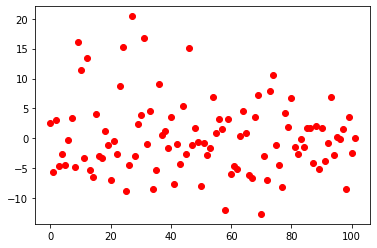

In [23]:
plt.plot(y_test - linear_regression_predict(x_test, beta_gradient), 'ro')
plt.show()

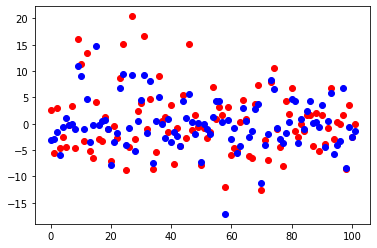

In [24]:
plt.plot(y_test - linear_regression_predict(x_test, beta_gradient), 'ro',
        y_test - linear_regression_predict(x_test, beta_normal), 'bo',)
plt.show()

## Discussion

Is this learning?
* No iterative learning steps in normal equation does not mean that the algorithm is not learning.
* Linear regression profits a lot from its easy form. This makes the algorithm explainable.

Normal equation vs gradient descent
* Calculating inverse matrix is difficult for many features. Updating rule stays easy.
* Learning rate has to be chosen well for gradient descent to work. So the learning algorithm gets more difficult. --> See also Class 4

Theoretical bounds
* Consider a data set $(x^{(i)},y_i)_{i=1,…,n}$ following the model $y = x^t β + ε$ for i.i.d. noise $ε$ with mean 0 and variance $σ^2$.
* The training error satisfies $\mathbb{E}[R(β)] = σ^2 (1−\frac{d+1}{n_{test}})$.
* The test error satisfies $\mathbb{E}[R(β)] = σ^2 (1+\frac{d+1}{n_{train}})$.
* This shows that the model is indeed learning some information from the noise as well.


## Practice yourself!

Play around with the code yourself! Possible ideas that might lead you to interesting observations are:
1. Try your algorithms on the new dataset diabetes from scikit-learn.
2. Implement the normalization. How do the results of your algorithms change?
3. Implement the algorithm for the absolute value loss function. Compare the estimator for the absolute value loss function with the one for the squared error.
4. Try your algorithm on a data set you generated yourself: Fix some $β∈ℝ^d$ with possibly some parameters being (close to) zero. Generate some samples via $y = \sum_{i=1}^d β_i x^{(i)} + ε$ with some i.i.d. noise $ε$.
5. Plot the training error and the test error for your model trained on smaller datasets of size $m\le n$ for different $m$. As $m$ increases, what can you see?